# Model Runners
We have several different models with runners that we utilized for our manuscript that I will cover in this notebook:
- [Fully Connected Network (FCN)](#fully-connected-network)
- [GraphSAGE (GCN)](#graphsage) 
- [BLSTM](#blstm)
- [ESM-BLSTM](#esm-blstm)
- [BERT-BLSTM](#bert-blstm)
    - [Initialized with Best Saved Spike NLP BERT Model](#initialized-with-best-saved-spike-nlp-bert-model)
    - [Initialized with ESM](#initialized-with-esm)

For running our models, we utilized 1 NVIDIA a100 80 GB GPUs at a time. It is recommended to utilize GPU over CPU due to improved performance.

# Transfer Learning Process
1) Run Spike NLP BERT model to generate `model_pth` for generating pickles. (see `model_runner_notes.ipynb`)
2) Generating Pickles/Embeddings (see `embedding_notes.ipynb`)
3) Executing Models (here)
    - With Pickles
    - Without Pickles

In [1]:
import os
import sys
import tqdm
import torch
import pickle
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Union
from prettytable import PrettyTable
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from transformers import AutoTokenizer, EsmModel 
from pnlp.embedding.tokenizer import ProteinTokenizer, token_to_index
from pnlp.model.language import ProteinMaskedLanguageModel, BERT

/data/miniconda3/envs/spike_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Below is from a script `runner_util.py` that includes several "utility" functions that are called from the model runners.
- `save_model`
- `count_parameters`
- `calc_train_test_history`
- `plot_rmse_history`
- `plot_run`

In [2]:
def save_model(model, optimizer: torch.optim.SGD, epoch: int, save_as: str):
    """
    Save model parameters.

    model: a model object
    optimizer: model optimizer
    epoch: number of epochs in the end of the model running
    save_as: file name for saveing the model.
    """
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},
                save_as)

def count_parameters(model):
    """
    Count model parameters and print a summary

    A nice hack from:
    https://stackoverflow.com/a/62508086/1992369
    """
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}\n")
    return total_params

def calc_train_test_history(metrics_csv: str, n_train: int, n_test: int, save_as: str):
    """ Calculate the average mse per item and rmse """

    history_df = pd.read_csv(metrics_csv, sep=',', header=0)

    history_df['train_loss_per'] = history_df['train_loss']/n_train  # average mse per item
    history_df['test_loss_per'] = history_df['test_loss']/n_test

    history_df['train_rmse'] = np.sqrt(history_df['train_loss_per'].values)  # rmse
    history_df['test_rmse'] = np.sqrt(history_df['test_loss_per'].values)

    history_df.to_csv(metrics_csv.replace('.csv', '_per.csv'), index=False)
    plot_rmse_history(history_df, save_as)

def plot_rmse_history(history_df, save_as: str):
    """ Plot RMSE training and testing history per epoch. """

    sns.set_theme()
    sns.set_context('talk')
    sns.set(style="darkgrid")

    # Converting mm to inches for figsize
    width_in = 88/25.4 # mm to inches
    ratio = 16/9
    height_in = width_in/ratio 
    fig, ax = plt.subplots(figsize=(width_in, height_in))
    plt.rcParams['font.family'] = 'sans-serif'

    # Plot
    sns.lineplot(data=history_df, x=history_df.index, y='test_rmse', color='tab:blue', linewidth=0.5, ax=ax) # add label='Test RMSE' for legend
    sns.lineplot(data=history_df, x=history_df.index, y='train_rmse', color='tab:orange', linewidth=0.5,ax=ax) # add label='Train RMSE' for legend
    
    # Set the font size
    font_size = 8
    ax.set_xlabel('Epoch', fontsize=font_size)
    ax.set_ylabel(f'RMSE', fontsize=font_size)
    ax.tick_params(axis='both', which='major', labelsize=font_size)
    # ax.legend(fontsize=font_size)

    # Skipping every other x-axis tick mark
    #ax.set_ylim(-0.1, 1.8)

    ax_xticks = ax.get_xticks()
    new_xlabels = ['' if i % 2 else label for i, label in enumerate(ax.get_xticklabels())]
    ax.set_xticks(ax_xticks)
    ax.set_xticklabels(new_xlabels)
    #ax.set_xlim(-100, 5000)

    plt.tight_layout()
    plt.savefig(save_as + '_rmse.pdf', format='pdf')

def plot_run(csv_name: str, save: bool = True):
    '''
    Generate a single figure with subplots for training loss and training accuracy
    from the model run csv file.

    For runner.py and gpu_ddp_runner.py
    '''
    df = pd.read_csv(csv_name)
    df.columns = df.columns.str.strip()

    sns.set_theme()
    sns.set_context('talk')
    sns.set(style="darkgrid")

    # Converting mm to inches for figsize
    width_in = 88/25.4 # mm to inches
    ratio = 16/9
    height_in = width_in/ratio 
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(width_in, 2*height_in))
    plt.rcParams['font.family'] = 'sans-serif'

    # Set the font size
    font_size = 8

    # Plot Training Loss
    train_loss_line = ax1.plot(df['epoch'], df['train_loss'], color='red', linewidth=0.5, label='Train Loss')
    test_loss_line = ax1.plot(df['epoch'], df['test_loss'], color='orange', linewidth=0.5, label='Test Loss')
    ax1.set_ylabel('Loss', fontsize=font_size)
    ax1.legend(loc='upper right', fontsize=font_size)
    ax1.tick_params(axis='both', which='major', labelsize=font_size)
    ax1.yaxis.get_offset_text().set_fontsize(font_size) 
    ax1.set_ylim(-0.5e6, 8e6) 

    # Plot Training Accuracy
    train_accuracy_line = ax2.plot(df['epoch'], df['train_accuracy']*100, color='blue', linewidth=0.5, label='Train Accuracy')
    test_accuracy_line = ax2.plot(df['epoch'], df['test_accuracy']*100, color='green', linewidth=0.5, label='Test Accuracy')
    ax2.set_xlabel('Epoch', fontsize=font_size)
    ax2.set_ylabel('Accuracy', fontsize=font_size)
    ax2.set_ylim(0, 100) 
    ax2.legend(loc='lower right', fontsize=font_size)
    ax2.tick_params(axis='both', which='major', labelsize=font_size)

    plt.tight_layout()

    if save:
        combined_fname = csv_name.replace('.csv', '_loss_acc.pdf')
        plt.savefig(combined_fname, format='pdf')

---
## Fully Connected Network
This section will cover the model runner found in `fcn_model_runner.py`. First, let's take a look at the fully connected network (FCN) model found in `fcn.py`, which we run using our model runner.

In [3]:
class FCN(nn.Module):
    """ Fully Connected Network """

    def __init__(self,
                 fcn_input_size,     # The number of input features
                 fcn_hidden_size,    # The number of features in hidden layer of FCN.
                 device):            # Device ('cpu' or 'cuda')
        super().__init__()
        self.device = device

        # FCN layers
        self.fcn = nn.Sequential(nn.Linear(fcn_input_size, fcn_hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(fcn_hidden_size, 1))  # Adjust this line based on the required output size

    def forward(self, x):
        fcn_out = self.fcn(x)
        fcn_final_out = fcn_out[:, -1, :]
        prediction = fcn_final_out.to(self.device)

        return prediction

Okay, now onto the model runner. Let's break it down:
- `EmbeddedDMSDataset`: Loads in the binding or expression DMS data set from the embedded pickle.
- `run_model`: Controller for running each epoch and writes out data. 
- `epoch_iteration`: Performs each epoch iteration as called by `run_model`.

Many of these model runners will look the same, but with slight differences. 

In [4]:
class EmbeddedDMSDataset(Dataset):
    """ Binding or Expression DMS Dataset """
    
    def __init__(self, pickle_file:str):
        """
        Load from pickle file:
        - sequence label (seq_id), 
        - binding or expression numerical target (log10Ka or ML_meanF), and 
        - embeddings
        """
        with open(pickle_file, 'rb') as f:
            dms_list = pickle.load(f)
        
            self.labels = [entry['seq_id'] for entry in dms_list]
            self.numerical = [entry["log10Ka" if "binding" in pickle_file else "ML_meanF"] for entry in dms_list]
            self.embeddings = [entry['embedding'] for entry in dms_list]

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx):
        # label, feature, target
        return self.labels[idx], self.embeddings[idx], self.numerical[idx]

def run_model(model, train_set, test_set, n_epochs: int, batch_size: int, lr:float, max_batch: Union[int, None], device: str, save_as: str):
    """ Run a model through train and test epochs. """
    
    if not max_batch:
        max_batch = len(train_set)

    model = model.to(device)
    loss_fn = nn.MSELoss(reduction='sum').to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr)

    train_loader = DataLoader(train_set, batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size, shuffle=True)
    
    metrics_csv = save_as + "_metrics.csv"

    with open(metrics_csv, "w") as fh:
        fh.write(f"epoch,"
                 f"train_loss,test_loss\n")

        for epoch in range(1, n_epochs + 1):
            train_loss = epoch_iteration(model, loss_fn, optimizer, train_loader, epoch, max_batch, device, mode='train')
            test_loss = epoch_iteration(model, loss_fn, optimizer, test_loader, epoch, max_batch, device, mode='test')

            print(f'Epoch {epoch} | Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}\n')
           
            fh.write(f"{epoch},"
                     f"{train_loss},{test_loss}\n")
            fh.flush()
                
            save_model(model, optimizer, epoch, save_as + '.model_save')

    return metrics_csv

def epoch_iteration(model, loss_fn, optimizer, data_loader, num_epochs: int, max_batch: int, device: str, mode: str):
    """ Used in run_model. """
    
    model.train() if mode=='train' else model.eval()

    data_iter = tqdm.tqdm(enumerate(data_loader),
                          desc=f'Epoch_{mode}: {num_epochs}',
                          total=len(data_loader),
                          bar_format='{l_bar}{r_bar}')

    total_loss = 0

    for batch, batch_data in data_iter:
        if max_batch > 0 and batch >= max_batch:
            break 
        
        label, feature, target = batch_data
        feature, target = feature.to(device), target.to(device) 
        target = target.float()

        if mode == 'train':
            optimizer.zero_grad()
            pred = model(feature).flatten()
            batch_loss = loss_fn(pred, target)
            batch_loss.backward()
            optimizer.step()

        else:
            with torch.no_grad():
                pred = model(feature).flatten()
                batch_loss = loss_fn(pred, target)
                
        total_loss += batch_loss.item()

    return total_loss

Let's run the FCN model runner now. For this model and all future models, we'll use the binding data set. For this one in particular, we'll use the one that has been pickled using the esm model. Again, most of these will look very similar. Let's define a few of the parameters that you can adjust.
- `embedded_train_pickle`: Path to embedded train pickle. Adjust `result_tag` with chosen dataset.
- `embedded_test_pickle`: Path to embedded test pickle. Make sure data set and `result_tag` matches with `embedded_train_pickle`.
- `n_epochs`: Number of epochs.
- `batch_size`: Batch size of DataLoader.
- `max_batch`: Number of batches needed to fulfill one epoch.
- `lr`: Learning rate.
- `device`: Set to use GPU, rather than CPU. Could probably be changed to utilize CPU, but may be considerably slower.

We'll run it with a small number of epochs, and a small max_batch. Don't expect that great of results with such a small amount of data, though.

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| fcn.0.weight |   102400   |
|  fcn.0.bias  |    320     |
| fcn.2.weight |    320     |
|  fcn.2.bias  |     1      |
+--------------+------------+
Total Trainable Params: 103041



Epoch_test: 1:  30%|| 200/660 [00:00<00:00, 2810.31it/s]


Epoch 1 | Train Loss: 71700.4951, Test Loss: 23209.0602



Epoch_test: 2:  30%|| 200/660 [00:00<00:00, 2924.65it/s]


Epoch 2 | Train Loss: 23317.9382, Test Loss: 23287.0441



Epoch_test: 3:  30%|| 200/660 [00:00<00:00, 2920.73it/s]


Epoch 3 | Train Loss: 23261.3610, Test Loss: 23369.2739



Epoch_test: 4:  30%|| 200/660 [00:00<00:00, 2945.22it/s]


Epoch 4 | Train Loss: 23460.2872, Test Loss: 23362.6310



Epoch_test: 5:  30%|| 200/660 [00:00<00:00, 2920.96it/s]


Epoch 5 | Train Loss: 23289.6424, Test Loss: 23379.1215



Epoch_test: 6:  30%|| 200/660 [00:00<00:00, 2963.97it/s]


Epoch 6 | Train Loss: 23381.7331, Test Loss: 23616.8574



Epoch_test: 7:  30%|| 200/660 [00:00<00:00, 2942.07it/s]


Epoch 7 | Train Loss: 23223.8068, Test Loss: 23238.0779



Epoch_test: 8:  30%|| 200/660 [00:00<00:00, 2945.20it/s]


Epoch 8 | Train Loss: 23162.0829, Test Loss: 23351.3438



Epoch_test: 9:  30%|| 200/660 [00:00<00:00, 2938.79it/s]


Epoch 9 | Train Loss: 23235.7421, Test Loss: 23320.8025



Epoch_test: 10:  30%|| 200/660 [00:00<00:00, 2935.33it/s]


Epoch 10 | Train Loss: 23096.5330, Test Loss: 23369.3088



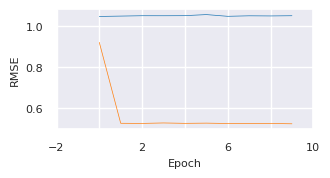

In [5]:
# Data/results directories
result_tag = 'fcn-esm_dms_binding' # specify rbd_learned or esm, and expression or binding
data_dir = '../data/pickles'
results_dir = '../results/run_results/fcn'

# Create run directory for results
now = datetime.datetime.now()
date_hour_minute = now.strftime("%Y-%m-%d_%H-%M")
run_dir = os.path.join(results_dir, f"{result_tag}-{date_hour_minute}")
os.makedirs(run_dir, exist_ok = True)

# Load in data
# embedded_train_pkl = os.path.join(data_dir, 'dms_mutation_expression_meanFs_train_esm_embedded.pkl') # fcn-esm_dms_expression
# embedded_test_pkl = os.path.join(data_dir, 'dms_mutation_expression_meanFs_test_esm_embedded.pkl')
embedded_train_pkl = os.path.join(data_dir, 'dms_mutation_binding_Kds_train_esm_embedded.pkl') # fcn-esm_dms_binding
embedded_test_pkl = os.path.join(data_dir, 'dms_mutation_binding_Kds_test_esm_embedded.pkl')
# embedded_train_pkl = os.path.join(data_dir, 'dms_mutation_expression_meanFs_train_rbd_learned_embedded_320.pkl') # fcn-rbd_learned_320_dms_expression
# embedded_test_pkl = os.path.join(data_dir, 'dms_mutation_expression_meanFs_test_rbd_learned_embedded_320.pkl')
# embedded_train_pkl = os.path.join(data_dir, 'dms_mutation_binding_Kds_train_rbd_learned_embedded_320.pkl') # fcn-rbd_learned_320_dms_binding
# embedded_test_pkl = os.path.join(data_dir, 'dms_mutation_binding_Kds_test_rbd_learned_embedded_320.pkl')

train_dataset = EmbeddedDMSDataset(embedded_train_pkl)
test_dataset = EmbeddedDMSDataset(embedded_test_pkl)

# Run setup
n_epochs = 10
batch_size = 32
max_batch = 200
lr = 1e-5
device = torch.device("cuda:0")

# FCN input
fcn_input_size = train_dataset.embeddings[0].size(1)   
fcn_hidden_size = fcn_input_size
model = FCN(fcn_input_size, fcn_hidden_size, device)

# Run
count_parameters(model)
model_result = os.path.join(run_dir, f"{result_tag}-{date_hour_minute}_train_{len(train_dataset)}_test_{len(test_dataset)}")
metrics_csv = run_model(model, train_dataset, test_dataset, n_epochs, batch_size, lr, max_batch, device, model_result)
calc_train_test_history(metrics_csv, len(train_dataset), len(test_dataset), model_result)


--- 
## GraphSAGE
Okay, let's move onto the GraphSAGE (GCN) model from `graphsage.py`. The model runner for this one is located in `graphsage_model_runner.py`. 

In [6]:
""" GraphSAGE model. """

class GraphSAGE(nn.Module):
    """ GraphSAGE. """

    def __init__(self, in_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, 16)
        self.conv2 = SAGEConv(16, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        return x

This `EmbeddedDMSDataset` is different than the previous one. This is because we need to convert the embeddings to a PyTorch geometric graph, meaning we need edges. We adjust this in the `__getitem__` function in the class. `run_model` is basically the same, but `epoch_iteration` is altered for predictions to work with the graph data and the GraphSAGE model.

In [7]:
class EmbeddedDMSDataset(Dataset):
    """ Binding or Expression DMS Dataset """
    
    def __init__(self, pickle_file:str):
        """
        Load from pickle file:
        - sequence label (seq_id), 
        - binding or expression numerical target (log10Ka or ML_meanF), and 
        - embeddings
        """
        with open(pickle_file, 'rb') as f:
            dms_list = pickle.load(f)
        
            self.labels = [entry['seq_id'] for entry in dms_list]
            self.numerical = [entry["log10Ka" if "binding" in pickle_file else "ML_meanF"] for entry in dms_list]
            self.embeddings = [entry['embedding'] for entry in dms_list]
 
    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert to pytorch geometric graph
        embedding = self.embeddings[idx]
        edges = [(i, i+1) for i in range(embedding.size(0) - 1)]
        edge_index = torch.tensor(edges, dtype=torch.int64).t().contiguous()
        y = torch.tensor([self.numerical[idx]], dtype=torch.float32).view(-1, 1)
        
        return Data(x=embedding, edge_index=edge_index, y=y)

def run_model(model, train_set, test_set, n_epochs: int, batch_size: int, lr:float, max_batch: Union[int, None], device: str, save_as: str):
    """ Run a model through train and test epochs. """
    
    if not max_batch:
        max_batch = len(train_set)

    model = model.to(device)
    loss_fn = nn.MSELoss(reduction='sum').to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr)

    train_loader = DataLoader(train_set, batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size, shuffle=True)
    
    metrics_csv = save_as + "_metrics.csv"

    with open(metrics_csv, "w") as fh:
        fh.write(f"epoch,"
                 f"train_loss,test_loss\n")

        for epoch in range(1, n_epochs + 1):
            train_loss = epoch_iteration(model, loss_fn, optimizer, train_loader, epoch, max_batch, device, mode='train')
            test_loss = epoch_iteration(model, loss_fn, optimizer, test_loader, epoch, max_batch, device, mode='test')

            print(f'Epoch {epoch} | Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}\n')
           
            fh.write(f"{epoch},"
                     f"{train_loss},{test_loss}\n")
            fh.flush()
                
            save_model(model, optimizer, epoch, save_as + '.model_save')

    return metrics_csv

def epoch_iteration(model, loss_fn, optimizer, data_loader, num_epochs: int, max_batch: int, device: str, mode: str):
    """ Used in run_model. """

    model.train() if mode=='train' else model.eval()

    data_iter = tqdm.tqdm(enumerate(data_loader),
                          desc=f'Epoch_{mode}: {num_epochs}',
                          total=len(data_loader),
                          bar_format='{l_bar}{r_bar}')

    total_loss = 0

    for batch, batch_data in data_iter:
        if max_batch > 0 and batch >= max_batch:
            break

        batch_data = batch_data.to(device)

        if mode == 'train':
            optimizer.zero_grad()
            pred = model(batch_data.x, batch_data.edge_index, batch_data.batch)
            batch_loss = loss_fn(pred, batch_data.y)
            batch_loss.backward()
            optimizer.step()

        else:
            with torch.no_grad():
                pred = model(batch_data.x, batch_data.edge_index, batch_data.batch)
                batch_loss = loss_fn(pred, batch_data.y)

        total_loss += batch_loss.item()

    return total_loss

Let's run this now. Pretty much everything is set as the same as before in the FCN model, but the input for the model is different.

+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
| conv1.lin_l.weight |    5120    |
|  conv1.lin_l.bias  |     16     |
| conv1.lin_r.weight |    5120    |
| conv2.lin_l.weight |     16     |
|  conv2.lin_l.bias  |     1      |
| conv2.lin_r.weight |     16     |
+--------------------+------------+
Total Trainable Params: 10289



Epoch_test: 1:  30%|| 200/660 [00:00<00:01, 232.70it/s]


Epoch 1 | Train Loss: 55353.6871, Test Loss: 23348.1994



Epoch_test: 2:  30%|| 200/660 [00:00<00:01, 233.30it/s]


Epoch 2 | Train Loss: 23142.0584, Test Loss: 23572.9299



Epoch_test: 3:  30%|| 200/660 [00:00<00:01, 233.07it/s]


Epoch 3 | Train Loss: 23286.5566, Test Loss: 23774.1481



Epoch_test: 4:  30%|| 200/660 [00:00<00:01, 234.53it/s]


Epoch 4 | Train Loss: 23239.0230, Test Loss: 23261.7439



Epoch_test: 5:  30%|| 200/660 [00:00<00:01, 233.69it/s]


Epoch 5 | Train Loss: 23071.9446, Test Loss: 23329.8421



Epoch_test: 6:  30%|| 200/660 [00:00<00:01, 233.16it/s]


Epoch 6 | Train Loss: 23330.0323, Test Loss: 23491.9236



Epoch_test: 7:  30%|| 200/660 [00:00<00:01, 232.96it/s]


Epoch 7 | Train Loss: 22931.6007, Test Loss: 23213.6893



Epoch_test: 8:  30%|| 200/660 [00:00<00:01, 233.42it/s]


Epoch 8 | Train Loss: 23103.3793, Test Loss: 23628.2105



Epoch_test: 9:  30%|| 200/660 [00:00<00:01, 232.92it/s]


Epoch 9 | Train Loss: 23203.3901, Test Loss: 23327.7919



Epoch_test: 10:  30%|| 200/660 [00:00<00:01, 233.34it/s]


Epoch 10 | Train Loss: 23148.2926, Test Loss: 23188.5589



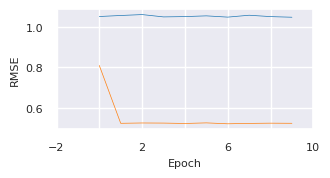

In [8]:
# Data/results directories
result_tag = 'graphsage-esm_dms_binding' # specify rbd_learned or esm, and expression or binding
data_dir = '../data/pickles'
results_dir = '../results/run_results/graphsage'

# Create run directory for results
now = datetime.datetime.now()
date_hour_minute = now.strftime("%Y-%m-%d_%H-%M")
run_dir = os.path.join(results_dir, f"{result_tag}-{date_hour_minute}")
os.makedirs(run_dir, exist_ok = True)

# Load in data
# embedded_train_pkl = os.path.join(data_dir, 'dms_mutation_expression_meanFs_train_esm_embedded.pkl') # graphsage-esm_dms_expression
# embedded_test_pkl = os.path.join(data_dir, 'dms_mutation_expression_meanFs_test_esm_embedded.pkl')
embedded_train_pkl = os.path.join(data_dir, 'dms_mutation_binding_Kds_train_esm_embedded.pkl') # graphsage-esm_dms_binding
embedded_test_pkl = os.path.join(data_dir, 'dms_mutation_binding_Kds_test_esm_embedded.pkl')
# embedded_train_pkl = os.path.join(data_dir, 'dms_mutation_expression_meanFs_train_rbd_learned_embedded_320.pkl') # graphsage-rbd_learned_320_dms_expression
# embedded_test_pkl = os.path.join(data_dir, 'dms_mutation_expression_meanFs_test_rbd_learned_embedded_320.pkl')
# embedded_train_pkl = os.path.join(data_dir, 'dms_mutation_binding_Kds_train_rbd_learned_embedded_320.pkl') # graphsage-rbd_learned_320_dms_binding
# embedded_test_pkl = os.path.join(data_dir, 'dms_mutation_binding_Kds_test_rbd_learned_embedded_320.pkl')
train_dataset = EmbeddedDMSDataset(embedded_train_pkl)
test_dataset = EmbeddedDMSDataset(embedded_test_pkl)

# Run setup
n_epochs = 10
batch_size = 32
max_batch = 200
lr = 1e-5
device = torch.device("cuda:0")

# GraphSAGE input
input_channels = train_dataset.embeddings[0].size(1) # number of input channels (dimensions of the embeddings)
out_channels = 1  # For regression output
model = GraphSAGE(input_channels, out_channels).to(device)

# Run
count_parameters(model)
model_result = os.path.join(run_dir, f"{result_tag}-{date_hour_minute}_train_{len(train_dataset)}_test_{len(test_dataset)}")
metrics_csv = run_model(model, train_dataset, test_dataset, n_epochs, batch_size, lr, max_batch, device, model_result)
calc_train_test_history(metrics_csv, len(train_dataset), len(test_dataset), model_result)

---
## BLSTM
Time for the BLSTM model from `blstm.py`. The model runner for this one is located in `blstm_model_runner.py`. Notably, this BLSTM model also has an FCN layer as well.

In [9]:
class BLSTM(nn.Module):
    """ Bidirectional LSTM with FCN layer. """

    def __init__(self,
                 lstm_input_size,    # The number of expected features.
                 lstm_hidden_size,   # The number of features in hidden state h.
                 lstm_num_layers,    # Number of recurrent layers in LSTM.
                 lstm_bidirectional, # Bidrectional LSTM.
                 fcn_hidden_size):   # The number of features in hidden layer of CN.
        super().__init__()

        # LSTM layer
        self.lstm = nn.LSTM(input_size=lstm_input_size,
                            hidden_size=lstm_hidden_size,
                            num_layers=lstm_num_layers,
                            bidirectional=lstm_bidirectional,
                            batch_first=True)           

        # FCN
        if lstm_bidirectional:
            self.fcn = nn.Sequential(nn.Linear(2 * lstm_hidden_size, fcn_hidden_size),
                                     nn.ReLU())
        else:
            self.fcn = nn.Sequential(nn.Linear(lstm_hidden_size, fcn_hidden_size),
                                     nn.ReLU())

        # FCN output layer
        self.out = nn.Linear(fcn_hidden_size, 1)

    def forward(self, x):
        num_directions = 2 if self.lstm.bidirectional else 1
        h_0 = torch.zeros(num_directions * self.lstm.num_layers, x.size(0), self.lstm.hidden_size, device=x.device)
        c_0 = torch.zeros(num_directions * self.lstm.num_layers, x.size(0), self.lstm.hidden_size, device=x.device)

        lstm_out, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        h_n.detach()
        c_n.detach()
        lstm_final_out = lstm_out[:, -1, :]
        fcn_out = self.fcn(lstm_final_out)
        prediction = self.out(fcn_out)

        return prediction


Nothing is different here than from FCN model runner.

In [10]:
class EmbeddedDMSDataset(Dataset):
    """ Binding or Expression DMS Dataset """
    
    def __init__(self, pickle_file:str):
        """
        Load from pickle file:
        - sequence label (seq_id), 
        - binding or expression numerical target (log10Ka or ML_meanF), and 
        - embeddings
        """
        with open(pickle_file, 'rb') as f:
            dms_list = pickle.load(f)
        
            self.labels = [entry['seq_id'] for entry in dms_list]
            self.numerical = [entry["log10Ka" if "binding" in pickle_file else "ML_meanF"] for entry in dms_list]
            self.embeddings = [entry['embedding'] for entry in dms_list]

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx):
        # label, feature, target
        return self.labels[idx], self.embeddings[idx], self.numerical[idx]

def run_model(model, train_set, test_set, n_epochs: int, batch_size: int, lr:float, max_batch: Union[int, None], device: str, save_as: str):
    """ Run a model through train and test epochs. """
    
    if not max_batch:
        max_batch = len(train_set)

    model = model.to(device)
    loss_fn = nn.MSELoss(reduction='sum').to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr)

    train_loader = DataLoader(train_set, batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size, shuffle=True)
    
    metrics_csv = save_as + "_metrics.csv"

    with open(metrics_csv, "w") as fh:
        fh.write(f"epoch,"
                 f"train_loss,test_loss\n")

        for epoch in range(1, n_epochs + 1):
            train_loss = epoch_iteration(model, loss_fn, optimizer, train_loader, epoch, max_batch, device, mode='train')
            test_loss = epoch_iteration(model, loss_fn, optimizer, test_loader, epoch, max_batch, device, mode='test')

            print(f'Epoch {epoch} | Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}\n')
           
            fh.write(f"{epoch},"
                     f"{train_loss},{test_loss}\n")
            fh.flush()
                
            save_model(model, optimizer, epoch, save_as + '.model_save')

    return metrics_csv

def epoch_iteration(model, loss_fn, optimizer, data_loader, num_epochs: int, max_batch: int, device: str, mode: str):
    """ Used in run_model. """
    
    model.train() if mode=='train' else model.eval()

    data_iter = tqdm.tqdm(enumerate(data_loader),
                          desc=f'Epoch_{mode}: {num_epochs}',
                          total=len(data_loader),
                          bar_format='{l_bar}{r_bar}')

    total_loss = 0

    for batch, batch_data in data_iter:
        if max_batch > 0 and batch >= max_batch:
            break 
        
        label, feature, target = batch_data
        feature, target = feature.to(device), target.to(device) 
        target = target.float()

        if mode == 'train':
            optimizer.zero_grad()
            pred = model(feature).flatten()
            batch_loss = loss_fn(pred, target)
            batch_loss.backward()
            optimizer.step()

        else:
            with torch.no_grad():
                pred = model(feature).flatten()
                batch_loss = loss_fn(pred, target)
                
        total_loss += batch_loss.item()

    return total_loss

Time to run! More of the same settings here, other than how we set up the model. Note that the `lstm_input_size`, `lstm_hidden_size`, and `fcn_hidden_size` are all 320. These sizes should match the dimension of the embedding pickle. 

+---------------------------+------------+
|          Modules          | Parameters |
+---------------------------+------------+
|     lstm.weight_ih_l0     |   409600   |
|     lstm.weight_hh_l0     |   409600   |
|      lstm.bias_ih_l0      |    1280    |
|      lstm.bias_hh_l0      |    1280    |
| lstm.weight_ih_l0_reverse |   409600   |
| lstm.weight_hh_l0_reverse |   409600   |
|  lstm.bias_ih_l0_reverse  |    1280    |
|  lstm.bias_hh_l0_reverse  |    1280    |
|        fcn.0.weight       |   204800   |
|         fcn.0.bias        |    320     |
|         out.weight        |    320     |
|          out.bias         |     1      |
+---------------------------+------------+
Total Trainable Params: 1848961



Epoch_test: 1:  30%|| 200/660 [00:00<00:01, 269.43it/s]


Epoch 1 | Train Loss: 193366.7646, Test Loss: 23361.6027



Epoch_test: 2:  30%|| 200/660 [00:00<00:01, 270.48it/s]


Epoch 2 | Train Loss: 23115.3184, Test Loss: 23506.8676



Epoch_test: 3:  30%|| 200/660 [00:00<00:01, 270.56it/s]


Epoch 3 | Train Loss: 23451.6085, Test Loss: 23333.1691



Epoch_test: 4:  30%|| 200/660 [00:00<00:01, 271.29it/s]


Epoch 4 | Train Loss: 23174.9963, Test Loss: 23235.8091



Epoch_test: 5:  30%|| 200/660 [00:00<00:01, 270.62it/s]


Epoch 5 | Train Loss: 23446.0729, Test Loss: 23508.0347



Epoch_test: 6:  30%|| 200/660 [00:00<00:01, 270.25it/s]


Epoch 6 | Train Loss: 23317.2330, Test Loss: 23308.7050



Epoch_test: 7:  30%|| 200/660 [00:00<00:01, 270.29it/s]


Epoch 7 | Train Loss: 22965.3556, Test Loss: 23561.0559



Epoch_test: 8:  30%|| 200/660 [00:00<00:01, 269.60it/s]


Epoch 8 | Train Loss: 23337.9955, Test Loss: 23566.0002



Epoch_test: 9:  30%|| 200/660 [00:00<00:01, 269.77it/s]


Epoch 9 | Train Loss: 23349.3475, Test Loss: 23552.4775



Epoch_test: 10:  30%|| 200/660 [00:00<00:01, 269.50it/s]


Epoch 10 | Train Loss: 23278.4862, Test Loss: 23235.9194



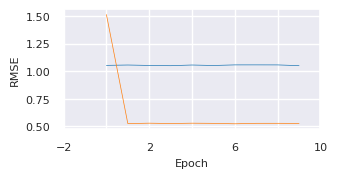

In [11]:
# Data/results directories
result_tag = 'blstm-esm_dms_binding' # specify expression or binding, esm or rbd_learned
data_dir = '../data/pickles'
results_dir = '../results/run_results/blstm'

# Create run directory for results
now = datetime.datetime.now()
date_hour_minute = now.strftime("%Y-%m-%d_%H-%M")
run_dir = os.path.join(results_dir, f"{result_tag}-{date_hour_minute}")
os.makedirs(run_dir, exist_ok = True)

# Load in data (from pickle)
# embedded_train_pkl = os.path.join(data_dir, 'dms_mutation_expression_meanFs_train_esm_embedded.pkl') # blstm-esm_dms_expression
# embedded_test_pkl = os.path.join(data_dir, 'dms_mutation_expression_meanFs_test_esm_embedded.pkl')
embedded_train_pkl = os.path.join(data_dir, 'dms_mutation_binding_Kds_train_esm_embedded.pkl') # blstm-esm_dms_binding
embedded_test_pkl = os.path.join(data_dir, 'dms_mutation_binding_Kds_test_esm_embedded.pkl')
# embedded_train_pkl = os.path.join(data_dir, 'dms_mutation_expression_meanFs_train_rbd_learned_embedded_320.pkl') # blstm-rbd_learned_320_dms_expression
# embedded_test_pkl = os.path.join(data_dir, 'dms_mutation_expression_meanFs_test_rbd_learned_embedded_320.pkl')
# embedded_train_pkl = os.path.join(data_dir, 'dms_mutation_binding_Kds_train_rbd_learned_embedded_320.pkl') # blstm-rbd_learned_320_dms_binding
# embedded_test_pkl = os.path.join(data_dir, 'dms_mutation_binding_Kds_test_rbd_learned_embedded_320.pkl')
train_dataset = EmbeddedDMSDataset(embedded_train_pkl)
test_dataset = EmbeddedDMSDataset(embedded_test_pkl)

# Run setup
n_epochs = 10
batch_size = 32
max_batch = 200
lr = 1e-5
device = torch.device("cuda:0")

# BLSTM input
lstm_input_size = 320
lstm_hidden_size = 320
lstm_num_layers = 1        
lstm_bidrectional = True   
fcn_hidden_size = 320
model = BLSTM(lstm_input_size, lstm_hidden_size, lstm_num_layers, lstm_bidrectional, fcn_hidden_size)

# Run
count_parameters(model)
model_result = os.path.join(run_dir, f"{result_tag}-{date_hour_minute}_train_{len(train_dataset)}_test_{len(test_dataset)}")
metrics_csv = run_model(model, train_dataset, test_dataset, n_epochs, batch_size, lr, max_batch, device, model_result)
calc_train_test_history(metrics_csv, len(train_dataset), len(test_dataset), model_result)

---
## ESM-BLSTM
We also get a bit interesting here as well. Instead of pre-embedding our sequences and not updating the embedding weights throughout the model run, here we update the ESM model embedding weights and feed them into a BLSTM model. Again, not using a pickle.

In [12]:
class ESM_BLSTM(nn.Module):
    def __init__(self, esm, blstm):
        super().__init__()
        self.esm = esm
        self.blstm = blstm

    def forward(self, tokenized_seqs):
        with torch.set_grad_enabled(self.training):  # Enable gradients, managed by model.eval() or model.train() in epoch_iteration
            esm_output = self.esm(**tokenized_seqs).last_hidden_state
            reshaped_output = esm_output.squeeze(0)  
            output = self.blstm(reshaped_output)
        return output

Not much changes with this part.

In [13]:
class DMSDataset(Dataset):
    """ Binding or Expression DMS Dataset, not from pickle! """
    
    def __init__(self, csv_file:str):
        """
        Load from csv file into pandas:
        - sequence label ('labels'), 
        - binding or expression numerical target ('log10Ka' or 'ML_meanF'), and 
        - 'sequence'
        """
        try:
            self.full_df = pd.read_csv(csv_file, sep=',', header=0)
            self.target = 'log10Ka' if 'binding' in csv_file else 'ML_meanF'
        except (FileNotFoundError, pd.errors.ParserError, Exception) as e:
            print(f"Error reading in .csv file: {csv_file}\n{e}", file=sys.stderr)
            sys.exit(1)

    def __len__(self) -> int:
        return len(self.full_df)

    def __getitem__(self, idx):
        # label, seq, target
        return self.full_df['labels'][idx], self.full_df['sequence'][idx], self.full_df[self.target][idx]

def run_model(model, tokenizer, train_set, test_set, n_epochs: int, batch_size: int, lr:float, max_batch: Union[int, None], device: str, save_as: str):
    """ Run a model through train and test epochs. """
    
    if not max_batch:
        max_batch = len(train_set)

    model = model.to(device)
    loss_fn = nn.MSELoss(reduction='sum').to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr)

    train_loader = DataLoader(train_set, batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size, shuffle=True)

    metrics_csv = save_as + "_metrics.csv"
    
    with open(metrics_csv, "w") as fh:
        fh.write(f"epoch,"
                 f"train_loss,test_loss\n")

        for epoch in range(1, n_epochs + 1):
            train_loss = epoch_iteration(model, tokenizer, loss_fn, optimizer, train_loader, epoch, max_batch, device, mode='train')
            test_loss = epoch_iteration(model, tokenizer, loss_fn, optimizer, test_loader, epoch, max_batch, device, mode='test')

            print(f'Epoch {epoch} | Train BLSTM Loss: {train_loss:.4f}, Test BLSTM Loss: {test_loss:.4f}\n')
           
            fh.write(f"{epoch},"
                     f"{train_loss},{test_loss}\n")
            fh.flush()
                
            save_model(model, optimizer, epoch, save_as + '.model_save')

    return metrics_csv

def epoch_iteration(model, tokenizer, loss_fn, optimizer, data_loader, num_epochs: int, max_batch: int, device: str, mode: str):
    """ Used in run_model. """
    
    model.train() if mode=='train' else model.eval()

    data_iter = tqdm.tqdm(enumerate(data_loader),
                          desc=f'Epoch_{mode}: {num_epochs}',
                          total=len(data_loader),
                          bar_format='{l_bar}{r_bar}')

    total_loss = 0

    for batch, batch_data in data_iter:
        if max_batch > 0 and batch >= max_batch:
            break

        labels, seqs, targets = batch_data
        targets = targets.to(device).float()
        tokenized_seqs = tokenizer(seqs,return_tensors="pt").to(device)
   
        if mode == 'train':
            optimizer.zero_grad()
            pred = model(tokenized_seqs).flatten()
            batch_loss = loss_fn(pred, targets)
            batch_loss.backward()
            optimizer.step()

        else:
            with torch.no_grad():
                pred = model(tokenized_seqs).flatten()
                batch_loss = loss_fn(pred, targets)

        total_loss += batch_loss.item()

    return total_loss

Let's run this model now! Same settings as before, just the input of the model is different.

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


+---------------------------------------------------+------------+
|                      Modules                      | Parameters |
+---------------------------------------------------+------------+
|       esm.embeddings.word_embeddings.weight       |   10560    |
|     esm.embeddings.position_embeddings.weight     |   328320   |
|  esm.encoder.layer.0.attention.self.query.weight  |   102400   |
|   esm.encoder.layer.0.attention.self.query.bias   |    320     |
|   esm.encoder.layer.0.attention.self.key.weight   |   102400   |
|    esm.encoder.layer.0.attention.self.key.bias    |    320     |
|  esm.encoder.layer.0.attention.self.value.weight  |   102400   |
|   esm.encoder.layer.0.attention.self.value.bias   |    320     |
| esm.encoder.layer.0.attention.output.dense.weight |   102400   |
|  esm.encoder.layer.0.attention.output.dense.bias  |    320     |
|   esm.encoder.layer.0.attention.LayerNorm.weight  |    320     |
|    esm.encoder.layer.0.attention.LayerNorm.bias   |    320  

Epoch_test: 1:  30%|| 200/660 [00:05<00:12, 35.53it/s]


Epoch 1 | Train BLSTM Loss: 166411.8602, Test BLSTM Loss: 23503.8496



Epoch_test: 2:  30%|| 200/660 [00:05<00:12, 35.68it/s]


Epoch 2 | Train BLSTM Loss: 23416.8100, Test BLSTM Loss: 23556.2040



Epoch_test: 3:  30%|| 200/660 [00:05<00:12, 35.51it/s]


Epoch 3 | Train BLSTM Loss: 23618.5297, Test BLSTM Loss: 23621.6742



Epoch_test: 4:  30%|| 200/660 [00:05<00:12, 35.74it/s]


Epoch 4 | Train BLSTM Loss: 23303.2598, Test BLSTM Loss: 23375.5446



Epoch_test: 5:  30%|| 200/660 [00:05<00:12, 35.84it/s]


Epoch 5 | Train BLSTM Loss: 23250.4523, Test BLSTM Loss: 23282.2098



Epoch_test: 6:  30%|| 200/660 [00:05<00:12, 35.61it/s]


Epoch 6 | Train BLSTM Loss: 23188.1590, Test BLSTM Loss: 23444.7286



Epoch_test: 7:  30%|| 200/660 [00:05<00:12, 35.71it/s]


Epoch 7 | Train BLSTM Loss: 23099.1543, Test BLSTM Loss: 22960.0495



Epoch_test: 8:  30%|| 200/660 [00:05<00:12, 35.81it/s]


Epoch 8 | Train BLSTM Loss: 22433.2038, Test BLSTM Loss: 21682.4475



Epoch_test: 9:  30%|| 200/660 [00:05<00:12, 35.59it/s]


Epoch 9 | Train BLSTM Loss: 22069.7470, Test BLSTM Loss: 21054.2300



Epoch_test: 10:  30%|| 200/660 [00:05<00:12, 35.66it/s]


Epoch 10 | Train BLSTM Loss: 21204.8561, Test BLSTM Loss: 21775.3624



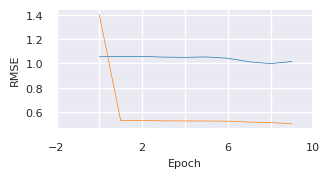

In [14]:
# Data/results directories
result_tag = 'esm-blstm-esm_dms_binding' # specify expression or binding
data_dir = '../data'
results_dir = '../results/run_results/esm-blstm'

# Create run directory for results
now = datetime.datetime.now()
date_hour_minute = now.strftime("%Y-%m-%d_%H-%M")
run_dir = os.path.join(results_dir, f"{result_tag}-{date_hour_minute}")
os.makedirs(run_dir, exist_ok = True)

# Load in data (from csv)
# dms_train_csv = os.path.join(data_dir, 'dms_mutation_expression_meanFs_train.csv') # esm-blstm-esm_dms_expression
# dms_test_csv = os.path.join(data_dir, 'dms_mutation_expression_meanFs_test.csv') 
dms_train_csv = os.path.join(data_dir, 'dms_mutation_binding_Kds_train.csv') # esm-blstm-esm_dms_binding
dms_test_csv = os.path.join(data_dir, 'dms_mutation_binding_Kds_test.csv') 
train_dataset = DMSDataset(dms_train_csv)
test_dataset = DMSDataset(dms_test_csv)

# Run setup
n_epochs = 10
batch_size = 32
max_batch = 200
lr = 1e-5
device = torch.device("cuda:0")

# ESM input
esm = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D").to(device)
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

# BLSTM input
lstm_input_size = 320
lstm_hidden_size = 320
lstm_num_layers = 1        
lstm_bidrectional = True   
fcn_hidden_size = 320
blstm = BLSTM(lstm_input_size, lstm_hidden_size, lstm_num_layers, lstm_bidrectional, fcn_hidden_size)

model = ESM_BLSTM(esm, blstm)

# Run
count_parameters(model)
model_result = os.path.join(run_dir, f"{result_tag}-{date_hour_minute}_train_{len(train_dataset)}_test_{len(test_dataset)}")
metrics_csv = run_model(model, tokenizer, train_dataset, test_dataset, n_epochs, batch_size, lr, max_batch, device, model_result)
calc_train_test_history(metrics_csv, len(train_dataset), len(test_dataset), model_result)

---
## BERT-BLSTM
Here, we get a little interesting. We combine the BERT model with the Protein Masked Languange model, and then pass it through to a BLTSM model. From this, we have two errors that are outputted that we later add together in the model runner. 

We need to adjust some of our scripts from the `runner_util.py` from earlier to account for these additional errors.

We have two versions of this model runner. One initialized with the ESM model embeddings, and the other with the best saved Spike NLP BERT model. The majority of the model runner is the same, except for the setup.

In [15]:
class BERT_BLSTM(nn.Module):
    """" BLSTM with FCN layer, MLM, and BERT. """
    
    def __init__(self, bert: BERT, blstm:BLSTM, vocab_size: int):
        super().__init__()

        self.bert = bert
        self.mlm = ProteinMaskedLanguageModel(self.bert.hidden, vocab_size)
        self.blstm = blstm

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.bert(x)
        error_1 = self.mlm(x) # error from masked language
        error_2 = self.blstm(x) # error from regession

        return error_1, error_2

In [16]:
def plot_combined_history(history_df: str, save_as):
    """
    Generate a single figure with subplots for combined training loss
    from the model run csv file.
    """
    sns.set_theme()
    sns.set_context('talk')
    sns.set(style="darkgrid")
    plt.ion()
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

    # Plot Training Loss
    train_loss_line = ax.plot(history_df['epoch'], history_df['train_combined_loss'], color='tab:orange', label='Train Loss')
    test_loss_line = ax.plot(history_df['epoch'], history_df['test_combined_loss'],color='tab:blue', label='Test Loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')

    # Skipping every other y-axis tick mark
    yticks = ax.get_yticks()
    ax.set_yticks(yticks[::2])  # Keep every other tick

    plt.style.use('ggplot')
    plt.tight_layout()
    plt.savefig(save_as+'_combined_loss.pdf', format='pdf')

def plot_mlm_history(history_df: str, save_as):
    """
    Generate a single figure with subplots for training loss and training accuracy
    from the model run csv file.
    """
    sns.set_theme()
    sns.set_context('talk')
    sns.set(style="darkgrid")
    plt.ion()
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 18))

    # Plot Training Loss
    train_loss_line = ax1.plot(history_df['epoch'], history_df['train_mlm_loss'], color='tab:red', label='Train Loss')
    test_loss_line = ax1.plot(history_df['epoch'], history_df['test_mlm_loss'],color='tab:orange', label='Test Loss')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')

    # Plot Training Accuracy
    train_accuracy_line = ax2.plot(history_df['epoch'], history_df['train_mlm_accuracy'], color='tab:blue', label='Train Accuracy')
    test_accuracy_line = ax2.plot(history_df['epoch'], history_df['test_mlm_accuracy'], color='tab:green', label='Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim(0, 1) 
    ax2.legend(loc='upper right')

    # Skipping every other y-axis tick mark
    a1_yticks = ax1.get_yticks()
    ax1.set_yticks(a1_yticks[::2])  # Keep every other tick

    plt.style.use('ggplot')
    plt.tight_layout()
    plt.savefig(save_as+'_loss_acc.pdf', format='pdf')

def plot_rmse_history(history_df, save_as: str):
    """ Plot RMSE training and testing history per epoch. """

    sns.set_theme()
    sns.set_context('talk')
    sns.set(style="darkgrid")
 
    fig, ax = plt.subplots(figsize=(16, 9))
    plt.rcParams['font.family'] = 'sans-serif'

    # Plot
    sns.lineplot(data=history_df, x=history_df.index, y='test_blstm_rmse', color='tab:blue', linewidth=0.5, ax=ax) # add label='Test RMSE' for legend
    sns.lineplot(data=history_df, x=history_df.index, y='train_blstm_rmse', color='tab:orange', linewidth=0.5,ax=ax) # add label='Train RMSE' for legend
    
    # Set the font size
    font_size = 8
    ax.set_xlabel('Epoch', fontsize=font_size)
    ax.set_ylabel(f'RMSE', fontsize=font_size)
    ax.tick_params(axis='both', which='major', labelsize=font_size)
    # ax.legend(fontsize=font_size)

    # Skipping every other y-, x-axis tick mark
    ax_yticks = ax.get_yticks()
    ax.set_ylim(-0.1, 1.8)

    ax_xticks = ax.get_xticks()
    new_xlabels = ['' if i % 2 else label for i, label in enumerate(ax.get_xticklabels())]
    ax.set_xticks(ax_xticks)
    ax.set_xticklabels(new_xlabels)
    #ax.set_xlim(-100, 5000)

    plt.tight_layout()
    plt.savefig(save_as + '_rmse.pdf', format='pdf')

def plot_all_loss_history(history_df, save_as:str):
    """ Plot error1 (MLM), error2 (BLSTM), and total_error training and testing history per epoch. """
    sns.set_theme()
    sns.set_context('talk')
    sns.set(style="darkgrid")
    fig, ax = plt.subplots(figsize=(16, 9))
    plt.rcParams['font.family'] = 'sans-serif'
    fontsize = 20

    # Color mapping
    palette = sns.color_palette("Paired", 10)
    
    # Plot
    sns.lineplot(data=history_df, x=history_df.index, y='test_mlm_loss', label='Test Error 1', color=palette[0], linewidth=2, ax=ax) 
    sns.lineplot(data=history_df, x=history_df.index, y='train_mlm_loss', label='Train Error 1', color=palette[1], linewidth=2, ax=ax)
    sns.lineplot(data=history_df, x=history_df.index, y='test_blstm_rmse', label='Test Error 2', color=palette[4], linewidth=2, ax=ax)
    sns.lineplot(data=history_df, x=history_df.index, y='train_blstm_rmse', label='Train Error 2', color=palette[5], linewidth=2, ax=ax)
    sns.lineplot(data=history_df, x=history_df.index, y='test_combined_loss', label='Test Combined Error', color=palette[8], linewidth=2, ax=ax)
    sns.lineplot(data=history_df, x=history_df.index, y='train_combined_loss', label='Train Combined Error', color=palette[9], linewidth=2, ax=ax)

    #ax.set_xlim(-100, 5000)
    ax_yticks = ax.get_yticks()
    ax.set_yticks(ax_yticks[::2])  # Keep every other tick
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.yaxis.get_offset_text().set_fontsize(fontsize) 

    ax.legend(fontsize=fontsize)
    ax.set_xlabel('Epoch', fontsize=fontsize)
    ax.set_ylabel('Loss', fontsize=fontsize)

    plt.style.use('ggplot')
    plt.tight_layout()
    plt.savefig(save_as + '_all_loss.pdf', format='pdf')

def calc_train_test_history(metrics_csv: str, n_train: int, n_test: int, save_as: str):
    """ Calculate the average mse per item and rmse """

    history_df = pd.read_csv(metrics_csv, sep=',', header=0)

    history_df['train_blstm_loss_per'] = history_df['train_blstm_loss']/n_train  # average mse per item
    history_df['test_blstm_loss_per'] = history_df['test_blstm_loss']/n_test

    history_df['train_blstm_rmse'] = np.sqrt(history_df['train_blstm_loss_per'].values)  # rmse
    history_df['test_blstm_rmse'] = np.sqrt(history_df['test_blstm_loss_per'].values)

    history_df.to_csv(save_as+'_metrics_per.csv', index=False)
    plot_mlm_history(history_df, save_as)
    plot_rmse_history(history_df, save_as)
    plot_combined_history(history_df, save_as)

In [17]:
class DMSDataset(Dataset):
    """ Binding or Expression DMS Dataset, not from pickle! """
    
    def __init__(self, csv_file:str):
        """
        Load from csv file into pandas:
        - sequence label ('labels'), 
        - binding or expression numerical target ('log10Ka' or 'ML_meanF'), and 
        - 'sequence'
        """
        try:
            self.full_df = pd.read_csv(csv_file, sep=',', header=0)
            self.target = 'log10Ka' if 'binding' in csv_file else 'ML_meanF'
        except (FileNotFoundError, pd.errors.ParserError, Exception) as e:
            print(f"Error reading in .csv file: {csv_file}\n{e}", file=sys.stderr)
            sys.exit(1)

    def __len__(self) -> int:
        return len(self.full_df)

    def __getitem__(self, idx):
        # label, seq, target
        return self.full_df['labels'][idx], self.full_df['sequence'][idx], self.full_df[self.target][idx]

def run_model(model, tokenizer, train_set, test_set, n_epochs: int, batch_size: int, max_batch: Union[int, None], alpha:float, lr:float, device: str, save_as: str):
    """ Run a model through train and test epochs. """
    
    if not max_batch:
        max_batch = len(train_set)

    model = model.to(device)
    regression_loss_fn = nn.MSELoss(reduction='sum').to(device) # blstm
    masked_language_loss_fn = nn.CrossEntropyLoss(reduction='sum').to(device) # mlm
    optimizer = torch.optim.SGD(model.parameters(), lr)

    train_loader = DataLoader(train_set, batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size, shuffle=True)

    metrics_csv = save_as + "_metrics.csv"

    with open(metrics_csv, "w") as fh:
        fh.write(f"epoch,"
                 f"train_mlm_accuracy,test_mlm_accuracy,"
                 f"train_mlm_loss,test_mlm_loss,"
                 f"train_blstm_loss,test_blstm_loss,"
                 f"train_combined_loss,test_combined_loss\n")

        for epoch in range(1, n_epochs + 1):
            train_mlm_accuracy, train_mlm_loss, train_blstm_loss, train_combined_loss = epoch_iteration(model, tokenizer, regression_loss_fn, masked_language_loss_fn, optimizer, train_loader, epoch, max_batch, alpha, device, mode='train')
            test_mlm_accuracy, test_mlm_loss, test_blstm_loss, test_combined_loss = epoch_iteration(model, tokenizer, regression_loss_fn, masked_language_loss_fn, optimizer, test_loader, epoch, max_batch, alpha, device, mode='test')

            print(f'Epoch {epoch} | Train MLM Acc: {train_mlm_accuracy:.4f}, Test MLM Acc: {test_mlm_accuracy:.4f}\n'
                  f'{" "*(len(str(epoch))+7)}| Train MLM Loss: {train_mlm_loss:.4f}, Test MLM Loss: {test_mlm_loss:.4f}\n'
                  f'{" "*(len(str(epoch))+7)}| Train BLSTM Loss: {train_blstm_loss:.4f}, Test BLSTM Loss: {test_blstm_loss:.4f}\n'
                  f'{" "*(len(str(epoch))+7)}| Train Combined Loss: {train_combined_loss:.4f}, Test Combined Loss: {test_combined_loss:.4f}\n')
            
            fh.write(f"{epoch},"
                     f"{train_mlm_accuracy},{test_mlm_accuracy},"
                     f"{train_mlm_loss},{test_mlm_loss},"
                     f"{train_blstm_loss},{test_blstm_loss},"
                     f"{train_combined_loss},{test_combined_loss}\n")
            fh.flush()
            
            save_model(model, optimizer, epoch, save_as + '.model_save')    

    return metrics_csv

def epoch_iteration(model, tokenizer, regression_loss_fn, masked_language_loss_fn, optimizer, data_loader, num_epochs: int, max_batch: int, alpha:float, device: str, mode: str):
    """ Used in run_model. """
    
    model.train() if mode=='train' else model.eval()

    data_iter = tqdm.tqdm(enumerate(data_loader),
                          desc=f'Epoch_{mode}: {num_epochs}',
                          total=len(data_loader),
                          bar_format='{l_bar}{r_bar}')

    total_mlm_loss = 0
    total_blstm_loss = 0
    total_combined_loss = 0
    total_masked = 0
    correct_predictions = 0

    for batch, batch_data in data_iter:
        if max_batch > 0 and batch >= max_batch:
            break

        labels, seqs, targets = batch_data
        masked_tokenized_seqs = tokenizer(seqs).to(device)
        unmasked_tokenized_seqs = tokenizer._batch_pad(seqs).to(device)
        target = targets.to(device).float()

        if mode == 'train':
            optimizer.zero_grad()
            mlm_pred, blstm_pred = model(masked_tokenized_seqs)
            batch_mlm_loss = masked_language_loss_fn(mlm_pred.transpose(1, 2), unmasked_tokenized_seqs)
            batch_blstm_loss = regression_loss_fn(blstm_pred.flatten(), target)
            combined_loss = batch_mlm_loss + (batch_blstm_loss * alpha)
            combined_loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                mlm_pred, blstm_pred = model(masked_tokenized_seqs)
                batch_mlm_loss = masked_language_loss_fn(mlm_pred.transpose(1, 2), unmasked_tokenized_seqs)
                batch_blstm_loss = regression_loss_fn(blstm_pred.flatten(), target)
                combined_loss = batch_mlm_loss + (batch_blstm_loss * alpha)

        # Loss
        total_mlm_loss += batch_mlm_loss.item()
        total_blstm_loss += batch_blstm_loss.item()
        total_combined_loss += combined_loss.item()

        # Accuracy
        predicted_tokens = torch.max(mlm_pred, dim=-1)[1]
        masked_locations = torch.nonzero(torch.eq(masked_tokenized_seqs, token_to_index['<MASK>']), as_tuple=True)
        correct_predictions += torch.eq(predicted_tokens[masked_locations], unmasked_tokenized_seqs[masked_locations]).sum().item()
        total_masked += masked_locations[0].numel()

    mlm_accuracy = correct_predictions / total_masked
    return mlm_accuracy, total_mlm_loss, total_blstm_loss, total_combined_loss

### Initialized with Best Saved Spike NLP BERT Model
Note that we utilize `DMSDataset` instead of `EmbeddedDMSDataset`. This is because this model updates the embeddings as the model runs, instead of being pre-embedded. For this initialized run, we load in the `model_pth` of our best saved model (320). We then access the `state_dict`, and separate out the BERT and MLM portions to load in later. Let's try it out!

+-----------------------------------------------------------+------------+
|                          Modules                          | Parameters |
+-----------------------------------------------------------+------------+
|           bert.embedding.token_embedding.weight           |    8960    |
|    bert.transformer_blocks.0.attention.linears.0.weight   |   102400   |
|     bert.transformer_blocks.0.attention.linears.0.bias    |    320     |
|    bert.transformer_blocks.0.attention.linears.1.weight   |   102400   |
|     bert.transformer_blocks.0.attention.linears.1.bias    |    320     |
|    bert.transformer_blocks.0.attention.linears.2.weight   |   102400   |
|     bert.transformer_blocks.0.attention.linears.2.bias    |    320     |
|    bert.transformer_blocks.0.attention.linears.3.weight   |   102400   |
|     bert.transformer_blocks.0.attention.linears.3.bias    |    320     |
|  bert.transformer_blocks.0.attention.output_linear.weight |   102400   |
|   bert.transformer_bloc

Epoch_test: 1:  30%|| 200/660 [00:06<00:15, 29.96it/s]


Epoch 1 | Train MLM Acc: 0.1583, Test MLM Acc: 0.4724
        | Train MLM Loss: 953451.3660, Test MLM Loss: 321335.4608
        | Train BLSTM Loss: 143780.5794, Test BLSTM Loss: 24785.3280
        | Train Combined Loss: 1097231.9478, Test Combined Loss: 346120.7896



Epoch_test: 2:  30%|| 200/660 [00:06<00:15, 29.93it/s]


Epoch 2 | Train MLM Acc: 0.4156, Test MLM Acc: 0.7997
        | Train MLM Loss: 398517.0729, Test MLM Loss: 193106.0308
        | Train BLSTM Loss: 23838.7679, Test BLSTM Loss: 25074.8188
        | Train Combined Loss: 422355.8416, Test Combined Loss: 218180.8492



Epoch_test: 3:  30%|| 200/660 [00:06<00:15, 29.81it/s]


Epoch 3 | Train MLM Acc: 0.5707, Test MLM Acc: 0.9121
        | Train MLM Loss: 297566.1627, Test MLM Loss: 140860.6191
        | Train BLSTM Loss: 23714.0596, Test BLSTM Loss: 23684.7461
        | Train Combined Loss: 321280.2225, Test Combined Loss: 164545.3647



Epoch_test: 4:  30%|| 200/660 [00:06<00:15, 29.75it/s]


Epoch 4 | Train MLM Acc: 0.6534, Test MLM Acc: 0.9439
        | Train MLM Loss: 248262.4012, Test MLM Loss: 113213.2491
        | Train BLSTM Loss: 23866.0492, Test BLSTM Loss: 24479.1740
        | Train Combined Loss: 272128.4508, Test Combined Loss: 137692.4232



Epoch_test: 5:  30%|| 200/660 [00:06<00:15, 29.56it/s]


Epoch 5 | Train MLM Acc: 0.7063, Test MLM Acc: 0.9547
        | Train MLM Loss: 217280.3745, Test MLM Loss: 97226.2792
        | Train BLSTM Loss: 23613.8358, Test BLSTM Loss: 25060.6739
        | Train Combined Loss: 240894.2102, Test Combined Loss: 122286.9529



Epoch_test: 6:  30%|| 200/660 [00:06<00:15, 29.47it/s]


Epoch 6 | Train MLM Acc: 0.7446, Test MLM Acc: 0.9802
        | Train MLM Loss: 196042.3592, Test MLM Loss: 86673.4081
        | Train BLSTM Loss: 23562.5311, Test BLSTM Loss: 23960.3146
        | Train Combined Loss: 219604.8898, Test Combined Loss: 110633.7227



Epoch_test: 7:  30%|| 200/660 [00:06<00:15, 29.37it/s]


Epoch 7 | Train MLM Acc: 0.7716, Test MLM Acc: 0.9755
        | Train MLM Loss: 181534.1868, Test MLM Loss: 79254.8401
        | Train BLSTM Loss: 23638.1195, Test BLSTM Loss: 23770.0409
        | Train Combined Loss: 205172.3062, Test Combined Loss: 103024.8812



Epoch_test: 8:  30%|| 200/660 [00:06<00:15, 30.35it/s]


Epoch 8 | Train MLM Acc: 0.7924, Test MLM Acc: 0.9843
        | Train MLM Loss: 170878.8323, Test MLM Loss: 74619.0070
        | Train BLSTM Loss: 23260.1478, Test BLSTM Loss: 23980.8724
        | Train Combined Loss: 194138.9810, Test Combined Loss: 98599.8794



Epoch_test: 9:  30%|| 200/660 [00:06<00:15, 29.61it/s]


Epoch 9 | Train MLM Acc: 0.8045, Test MLM Acc: 0.9841
        | Train MLM Loss: 161996.6497, Test MLM Loss: 70216.5813
        | Train BLSTM Loss: 23669.4923, Test BLSTM Loss: 24153.0391
        | Train Combined Loss: 185666.1428, Test Combined Loss: 94369.6204



Epoch_test: 10:  30%|| 200/660 [00:06<00:15, 29.85it/s]


Epoch 10 | Train MLM Acc: 0.8183, Test MLM Acc: 0.9842
         | Train MLM Loss: 154267.5236, Test MLM Loss: 67838.2606
         | Train BLSTM Loss: 23415.6866, Test BLSTM Loss: 23831.0887
         | Train Combined Loss: 177683.2100, Test Combined Loss: 91669.3493



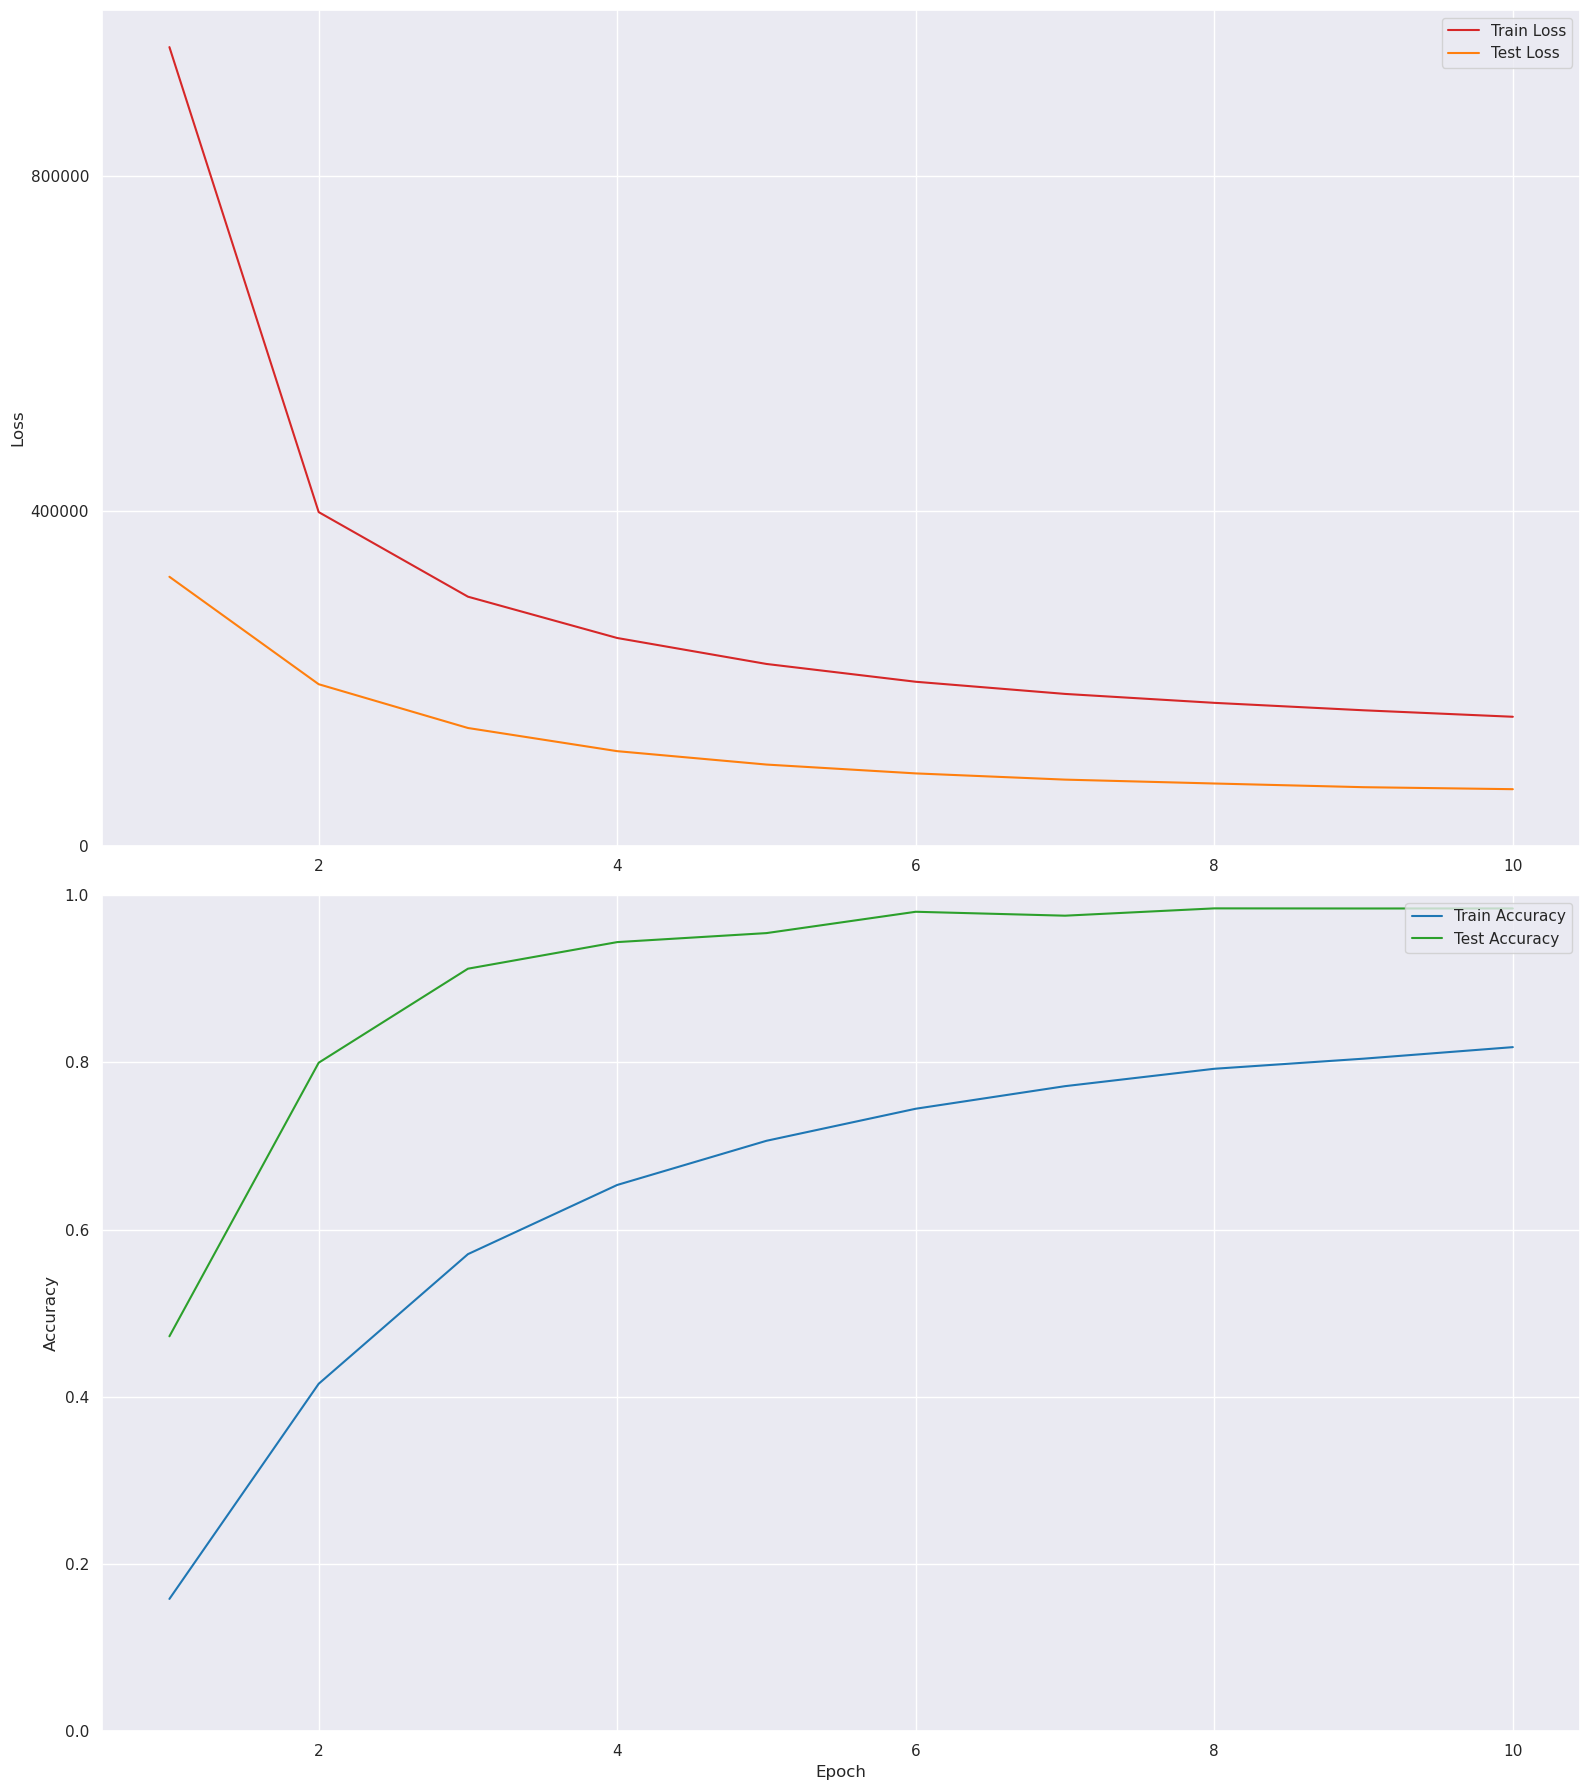

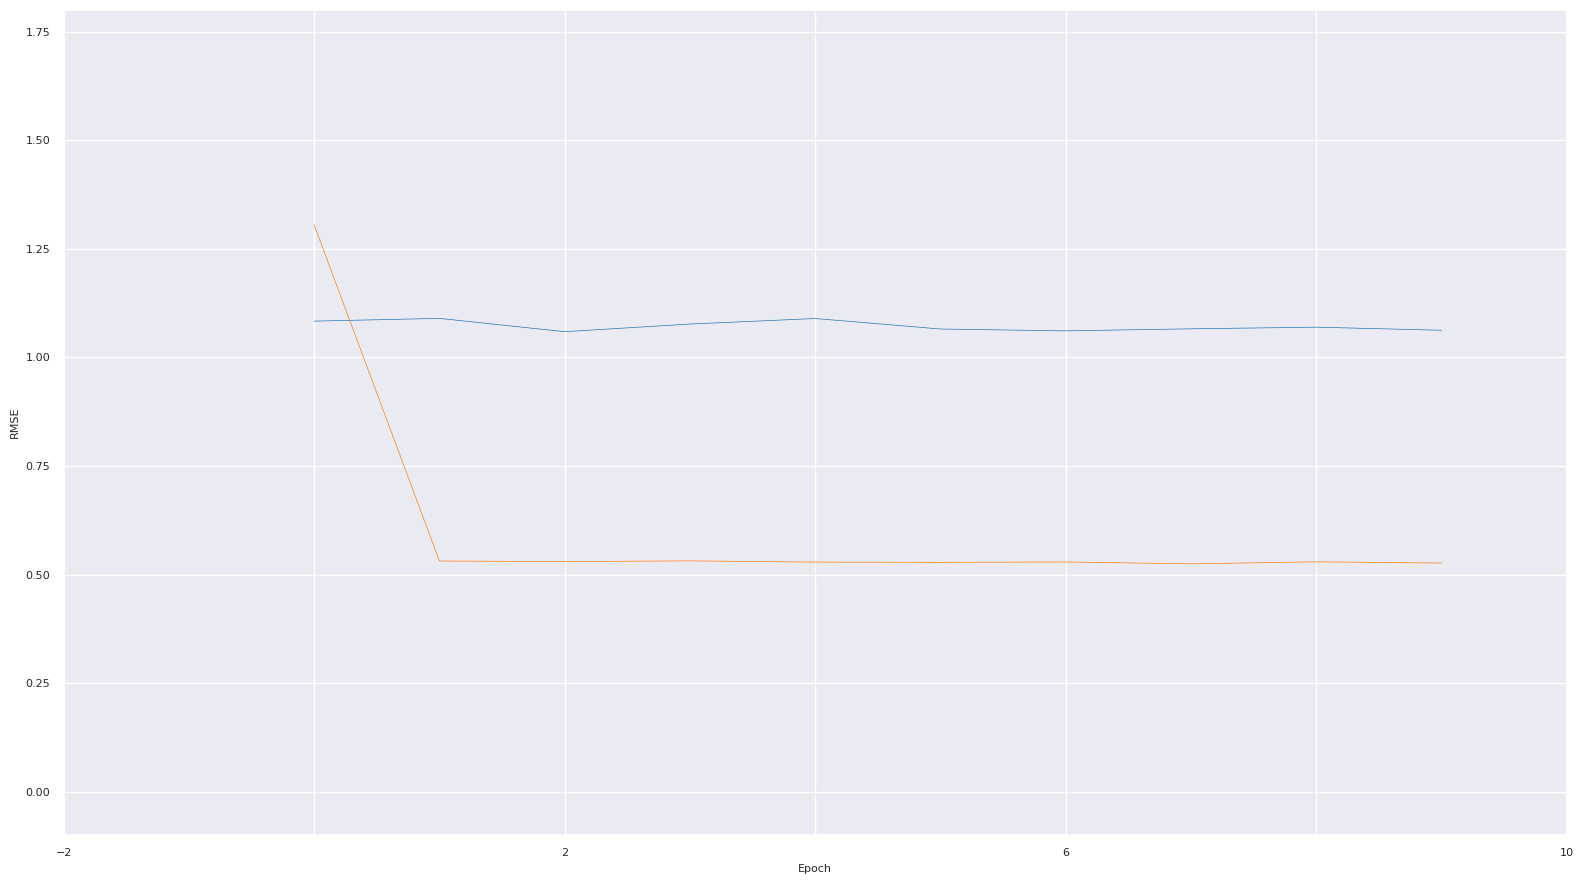

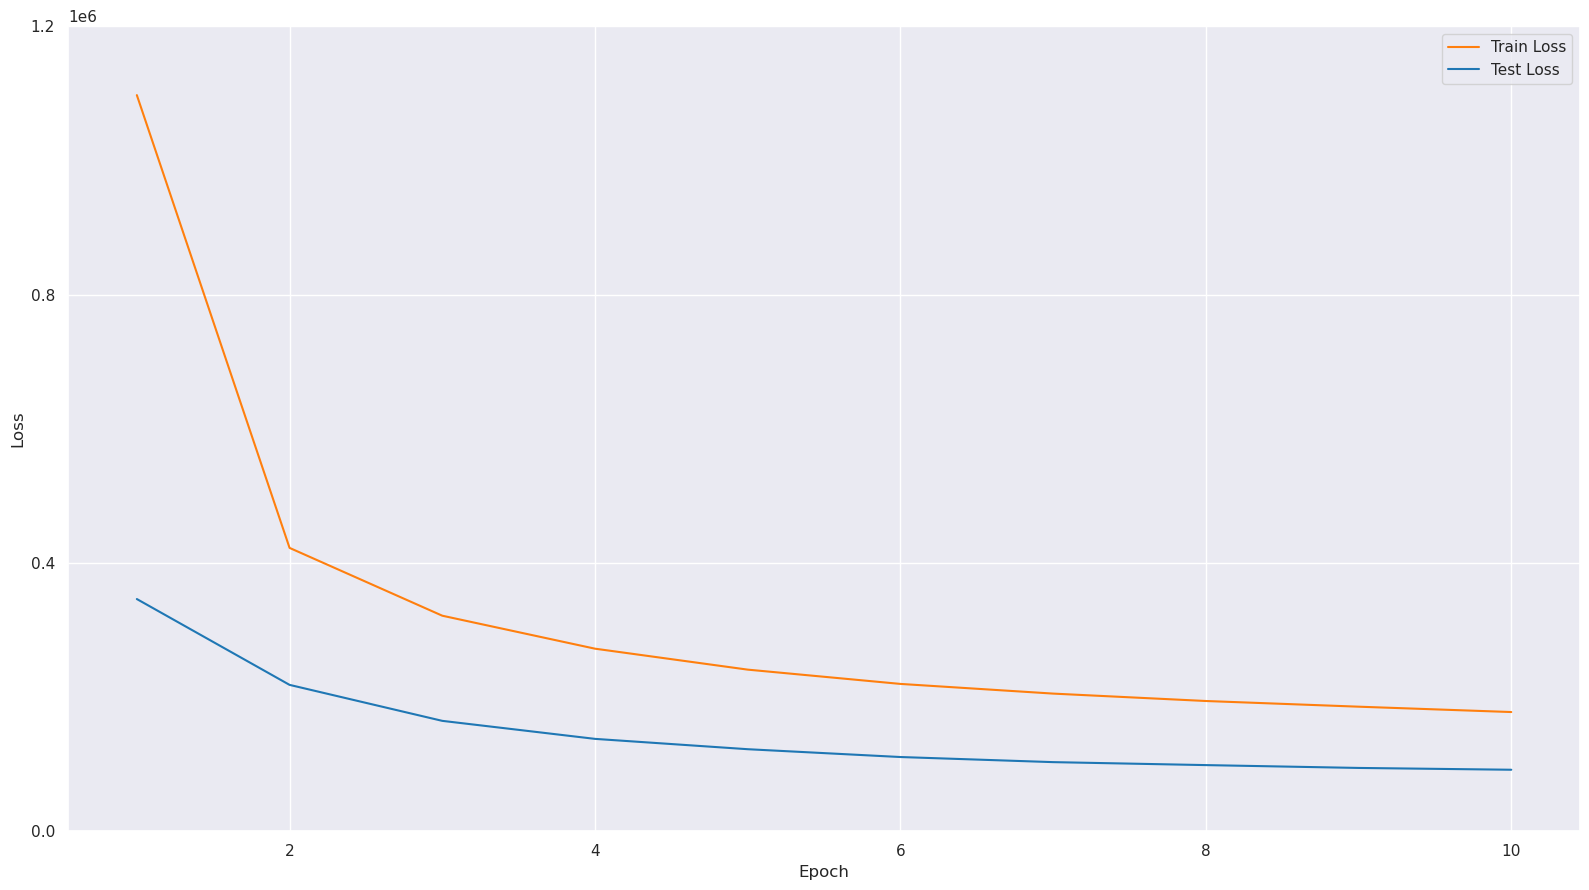

In [18]:
# Data/results directories
result_tag = 'bert_blstm-dms_binding' # specify expression or binding
data_dir = '../data'
results_dir = '../results/run_results/bert_blstm'

# Create run directory for results
now = datetime.datetime.now()
date_hour_minute = now.strftime("%Y-%m-%d_%H-%M")
run_dir = os.path.join(results_dir, f"{result_tag}-{date_hour_minute}")
os.makedirs(run_dir, exist_ok = True)

# Load in data
# dms_train_csv = os.path.join(data_dir, 'dms_mutation_expression_meanFs_train.csv') # bert_blstm-dms_expression
# dms_test_csv = os.path.join(data_dir, 'dms_mutation_expression_meanFs_test.csv') 
dms_train_csv = os.path.join(data_dir, 'dms_mutation_binding_Kds_train.csv') # bert_blstm-dms_binding
dms_test_csv = os.path.join(data_dir, 'dms_mutation_binding_Kds_test.csv') 
train_dataset = DMSDataset(dms_train_csv)
test_dataset = DMSDataset(dms_test_csv)

# Load pretrained spike model weights for BERT
model_pth = os.path.join(results_dir, '../ddp_runner/ddp-2023-10-06_20-16/ddp-2023-10-06_20-16_best_model_weights.pth') # 320 dim
saved_state = torch.load(model_pth, map_location='cuda')
state_dict = saved_state['model_state_dict']

# For loading from ddp models, they have 'module.bert.' or 'module.mlm.' in keys of state_dict
# Also need separated out for each corresponding model part
bert_state_dict = {key[len('module.bert.'):]: value for key, value in state_dict.items() if key.startswith('module.bert.')}
mlm_state_dict = {key[len('module.mlm.'):]: value for key, value in state_dict.items() if key.startswith('module.mlm.')}

# BERT input
max_len = 280
mask_prob = 0.15
embedding_dim = 320 
dropout = 0.1
n_transformer_layers = 12
n_attn_heads = 10
tokenizer = ProteinTokenizer(max_len, mask_prob)
bert = BERT(embedding_dim, dropout, max_len, mask_prob, n_transformer_layers, n_attn_heads)
bert.load_state_dict(bert_state_dict)

# BLSTM input
lstm_input_size = 320
lstm_hidden_size = 320
lstm_num_layers = 1        
lstm_bidrectional = True   
fcn_hidden_size = 320
blstm = BLSTM(lstm_input_size, lstm_hidden_size, lstm_num_layers, lstm_bidrectional, fcn_hidden_size)

# BERT_BLSTM input
vocab_size = len(token_to_index)
model = BERT_BLSTM(bert, blstm, vocab_size)
model.mlm.load_state_dict(mlm_state_dict)

# Run setup
n_epochs = 10
batch_size = 32
max_batch = 200
alpha = 1
lr = 1e-5
device = torch.device("cuda:0")

# Run
count_parameters(model)
model_result = os.path.join(run_dir, f"{result_tag}-{date_hour_minute}_train_{len(train_dataset)}_test_{len(test_dataset)}")
metrics_csv  = run_model(model, tokenizer, train_dataset, test_dataset, n_epochs, batch_size, max_batch, alpha, lr, device, model_result)
calc_train_test_history(metrics_csv, len(train_dataset), len(test_dataset), model_result)

### Initialized with ESM
For this initialization, we needed to match up the ESM model tokenizer tokens with our model's tokenizer. And also match up the `state_dict` embeddings properly with the tokens. You can see below in the function `create_esm_embedding` for a more detailed explanation of this process.

In [19]:
def create_esm_embedding(embedding_dim:int, save_location:str) -> tuple:
    """
    Map our tokenizer tokens used for NLP embedding and BERT to
    Huggingface AutoTokenizer tokens and their corresponding embedding
    weights in the ESM model. Then create an embedding file (.pth) to 
    be utilized as pretrained embedding weights for loading into the BERT model.
    Returns name of the embedding file and the vocab size.

    Inputs:
    - embedding_dim: MUST be the same as embedding dimension to be used for the BERT model.
    - save_location: Location to save embedding file.

    Be sure to import from Huggingface:
        from transformers import AutoTokenizer, EsmModel 
    """
    embedding_file = os.path.join(save_location, f"esm_embeddings_{embedding_dim}_dim.pth")

    # ESM input
    esm = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
    esm_embeddings = esm.embeddings.word_embeddings.weight
    esm_tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

    # Identifying tokens that exist in both datasets
    esm_tokens = esm_tokenizer.get_vocab()
    main_tokens = token_to_index

    # Manual mapping for special tokens that exist in both sets, main tokens as keys
    # '<TRUNCATED>' alternate does not exist in ESM
    special_token_mapping = {'<START>':'<cls>', 
                             '<PAD>':'<pad>', 
                             '<END>':'<eos>', 
                             '<OTHER>':'<unk>',
                             '<MASK>':'<mask>'}

    # Create the dictionary to map ESM embeddings to our tokens
    esm_embedding_map = {}
    for token in main_tokens:
        if token in esm_tokens:
            esm_embedding_map[main_tokens[token]] = esm_embeddings[esm_tokens[token]]
        elif token in special_token_mapping and special_token_mapping[token] in esm_tokens:
            esm_embedding_map[main_tokens[token]] = esm_embeddings[esm_tokens[special_token_mapping[token]]]

    # Create a ESM embedding tensor that can be loaded into BERT 
    vocab_size = len(esm_embedding_map.keys())
    esm_embeddings = torch.zeros(vocab_size, embedding_dim)  # Initialize a tensor of zeros
    for token, embedding in esm_embedding_map.items():
        esm_embeddings[token] = embedding
    torch.save(esm_embeddings, embedding_file)

    return embedding_file, vocab_size

Let's run it! Same settings as before, but instead we initialize the BERT embeddings by loading in the mapped ESM embeddings.

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


+-----------------------------------------------------------+------------+
|                          Modules                          | Parameters |
+-----------------------------------------------------------+------------+
|           bert.embedding.token_embedding.weight           |    8640    |
|    bert.transformer_blocks.0.attention.linears.0.weight   |   102400   |
|     bert.transformer_blocks.0.attention.linears.0.bias    |    320     |
|    bert.transformer_blocks.0.attention.linears.1.weight   |   102400   |
|     bert.transformer_blocks.0.attention.linears.1.bias    |    320     |
|    bert.transformer_blocks.0.attention.linears.2.weight   |   102400   |
|     bert.transformer_blocks.0.attention.linears.2.bias    |    320     |
|    bert.transformer_blocks.0.attention.linears.3.weight   |   102400   |
|     bert.transformer_blocks.0.attention.linears.3.bias    |    320     |
|  bert.transformer_blocks.0.attention.output_linear.weight |   102400   |
|   bert.transformer_bloc

Epoch_test: 1:  30%|| 200/660 [00:06<00:15, 29.20it/s]


Epoch 1 | Train MLM Acc: 0.3175, Test MLM Acc: 0.5234
        | Train MLM Loss: 1435753.9055, Test MLM Loss: 336085.2153
        | Train BLSTM Loss: 110166.1375, Test BLSTM Loss: 26161.7830
        | Train Combined Loss: 1545920.0469, Test Combined Loss: 362246.9979



Epoch_test: 2:  30%|| 200/660 [00:06<00:15, 29.30it/s]


Epoch 2 | Train MLM Acc: 0.3958, Test MLM Acc: 0.5862
        | Train MLM Loss: 425494.2953, Test MLM Loss: 239580.2777
        | Train BLSTM Loss: 23863.6700, Test BLSTM Loss: 25818.4354
        | Train Combined Loss: 449357.9644, Test Combined Loss: 265398.7134



Epoch_test: 3:  30%|| 200/660 [00:06<00:15, 28.94it/s]


Epoch 3 | Train MLM Acc: 0.4261, Test MLM Acc: 0.6043
        | Train MLM Loss: 350682.6875, Test MLM Loss: 217014.3194
        | Train BLSTM Loss: 23946.6022, Test BLSTM Loss: 25923.4636
        | Train Combined Loss: 374629.2897, Test Combined Loss: 242937.7826



Epoch_test: 4:  30%|| 200/660 [00:06<00:15, 29.20it/s]


Epoch 4 | Train MLM Acc: 0.4456, Test MLM Acc: 0.7257
        | Train MLM Loss: 320710.6072, Test MLM Loss: 191497.5116
        | Train BLSTM Loss: 23344.1807, Test BLSTM Loss: 25909.0661
        | Train Combined Loss: 344054.7877, Test Combined Loss: 217406.5779



Epoch_test: 5:  30%|| 200/660 [00:06<00:15, 29.37it/s]


Epoch 5 | Train MLM Acc: 0.4680, Test MLM Acc: 0.7507
        | Train MLM Loss: 297117.2329, Test MLM Loss: 180512.0012
        | Train BLSTM Loss: 23559.2934, Test BLSTM Loss: 26977.1777
        | Train Combined Loss: 320676.5264, Test Combined Loss: 207489.1784



Epoch_test: 6:  30%|| 200/660 [00:06<00:15, 29.27it/s]


Epoch 6 | Train MLM Acc: 0.4910, Test MLM Acc: 0.8016
        | Train MLM Loss: 279505.6218, Test MLM Loss: 166260.5228
        | Train BLSTM Loss: 23976.6156, Test BLSTM Loss: 24810.5504
        | Train Combined Loss: 303482.2368, Test Combined Loss: 191071.0734



Epoch_test: 7:  30%|| 200/660 [00:06<00:15, 29.33it/s]


Epoch 7 | Train MLM Acc: 0.5063, Test MLM Acc: 0.7620
        | Train MLM Loss: 265486.5967, Test MLM Loss: 164056.9193
        | Train BLSTM Loss: 23822.7009, Test BLSTM Loss: 26299.2905
        | Train Combined Loss: 289309.2970, Test Combined Loss: 190356.2097



Epoch_test: 8:  30%|| 200/660 [00:06<00:15, 29.65it/s]


Epoch 8 | Train MLM Acc: 0.5302, Test MLM Acc: 0.8515
        | Train MLM Loss: 252040.9298, Test MLM Loss: 148246.7216
        | Train BLSTM Loss: 23677.7212, Test BLSTM Loss: 26047.0733
        | Train Combined Loss: 275718.6512, Test Combined Loss: 174293.7951



Epoch_test: 9:  30%|| 200/660 [00:06<00:15, 29.24it/s]


Epoch 9 | Train MLM Acc: 0.5445, Test MLM Acc: 0.8666
        | Train MLM Loss: 241991.2423, Test MLM Loss: 140665.8517
        | Train BLSTM Loss: 23855.6690, Test BLSTM Loss: 26149.9465
        | Train Combined Loss: 265846.9120, Test Combined Loss: 166815.7980



Epoch_test: 10:  30%|| 200/660 [00:06<00:15, 29.30it/s]


Epoch 10 | Train MLM Acc: 0.5626, Test MLM Acc: 0.8521
         | Train MLM Loss: 231538.4686, Test MLM Loss: 137409.0112
         | Train BLSTM Loss: 23734.1637, Test BLSTM Loss: 24916.7233
         | Train Combined Loss: 255272.6317, Test Combined Loss: 162325.7346



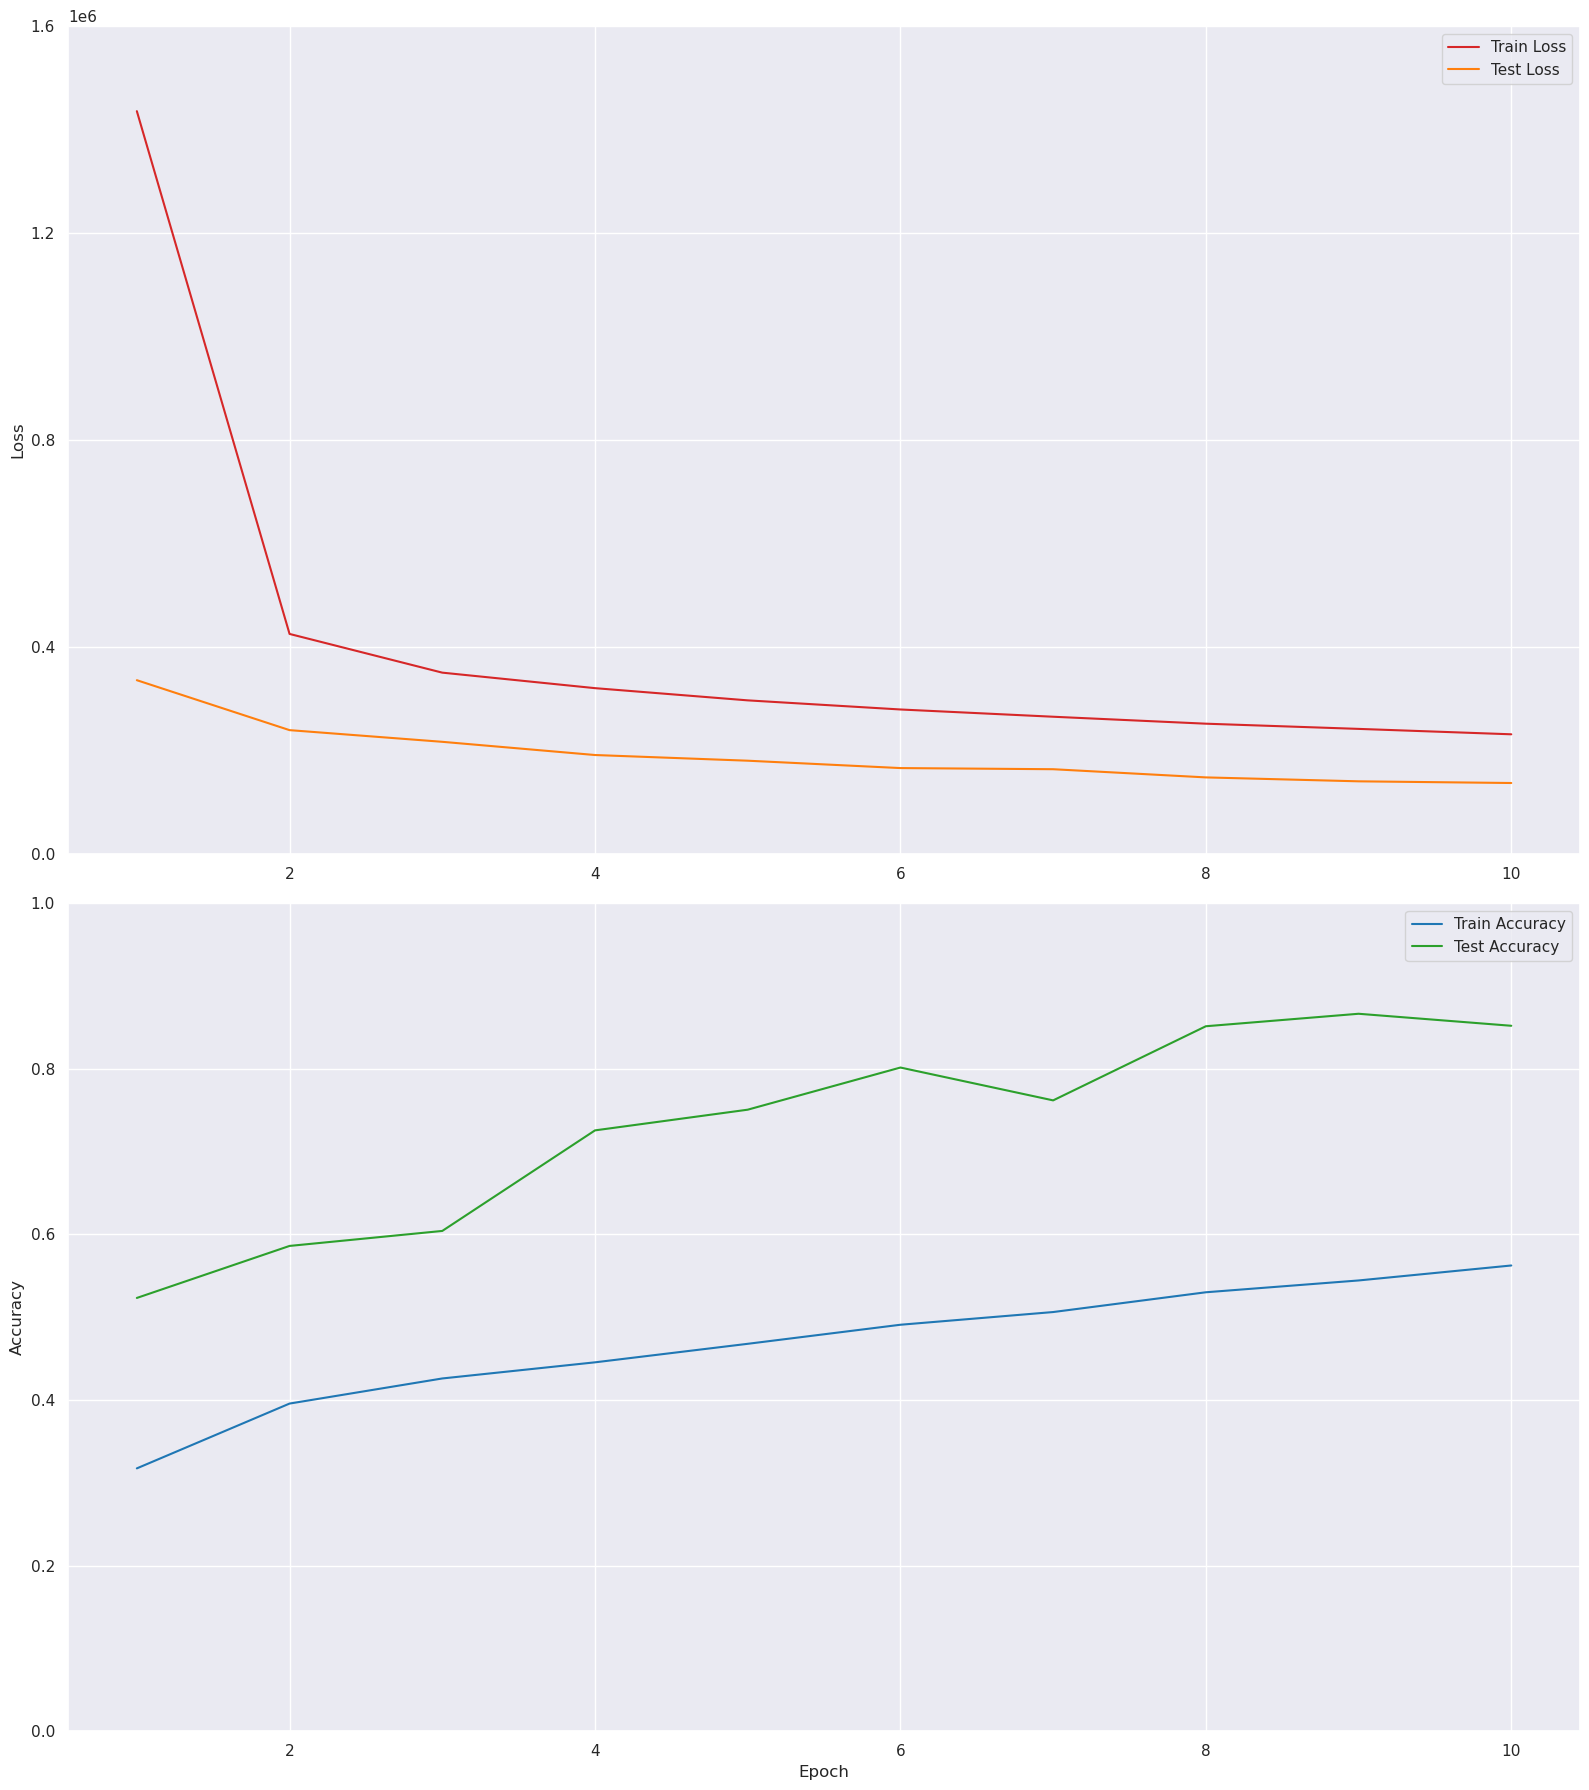

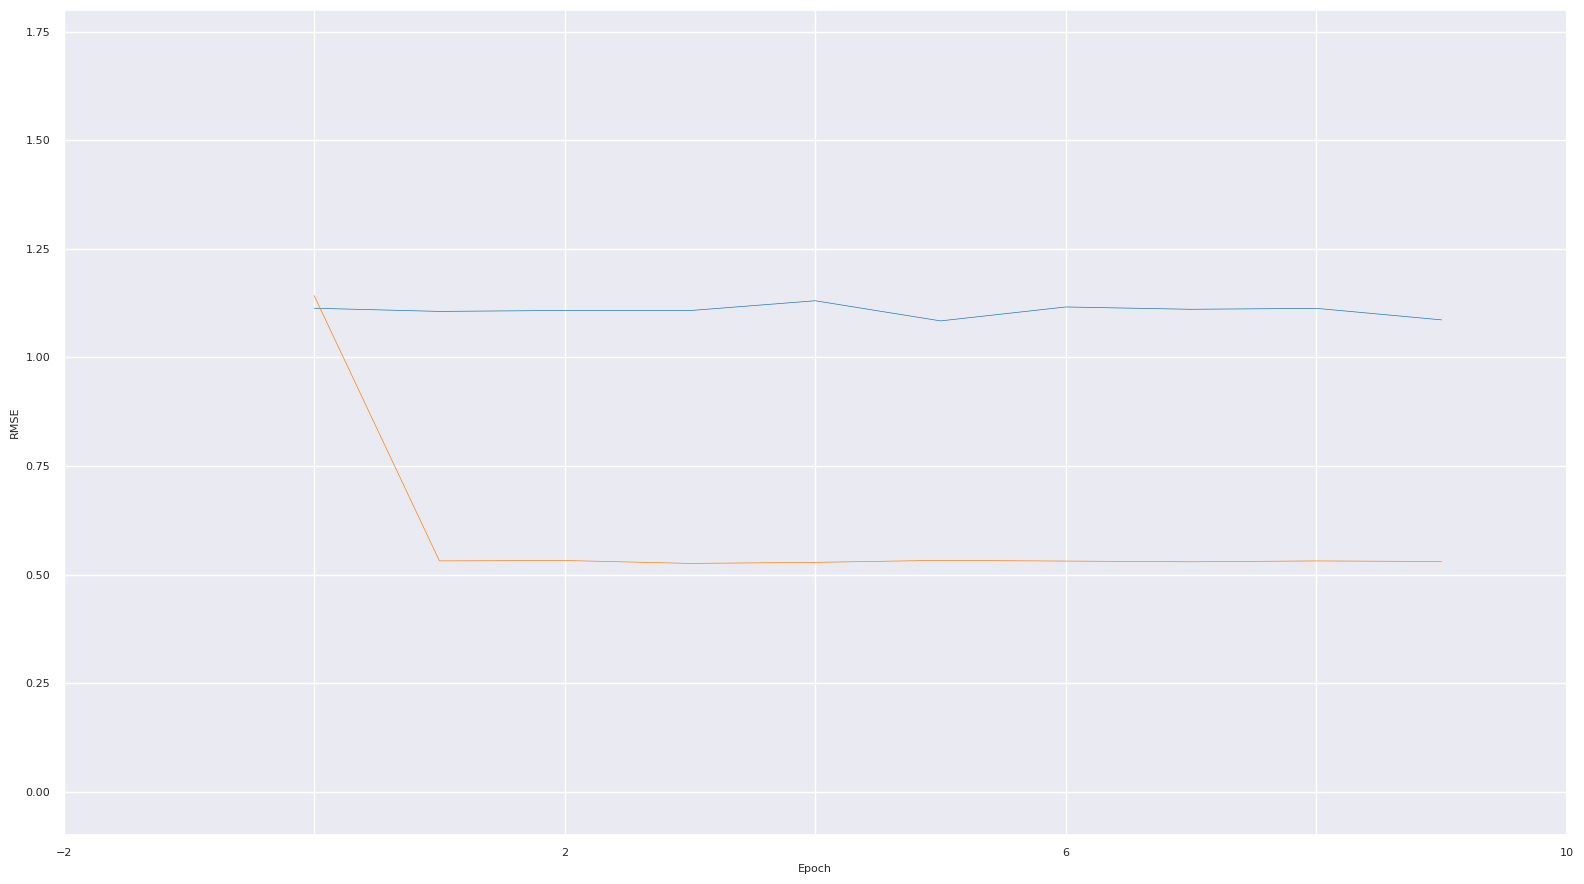

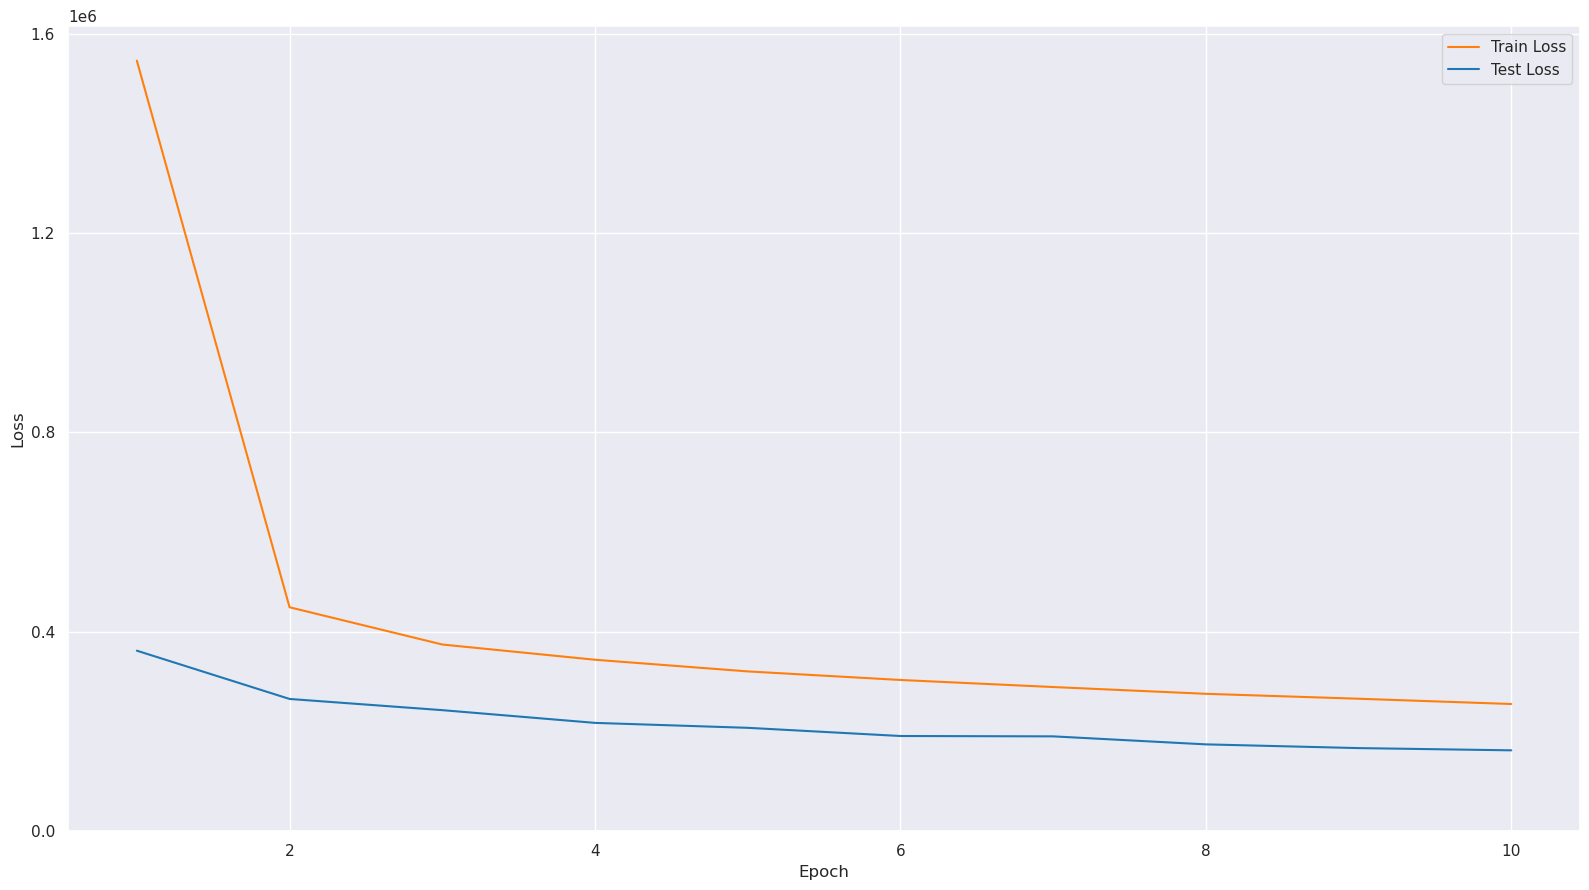

In [20]:
# Data/results directories
result_tag = 'bert_blstm_esm-dms_binding'
data_dir = '../data'
results_dir = '../results/run_results/bert_blstm_esm'

# Create run directory for results
now = datetime.datetime.now()
date_hour_minute = now.strftime("%Y-%m-%d_%H-%M")
run_dir = os.path.join(results_dir, f"{result_tag}-{date_hour_minute}")
os.makedirs(run_dir, exist_ok = True)

# Load in data
# dms_train_csv = os.path.join(data_dir, 'dms_mutation_expression_meanFs_train.csv') # 'bert_blstm_esm-dms_expression'
# dms_test_csv = os.path.join(data_dir, 'dms_mutation_expression_meanFs_test.csv') 
dms_train_csv = os.path.join(data_dir, 'dms_mutation_binding_Kds_train.csv') # 'bert_blstm_esm-dms_binding'
dms_test_csv = os.path.join(data_dir, 'dms_mutation_binding_Kds_test.csv') 
train_dataset = DMSDataset(dms_train_csv)
test_dataset = DMSDataset(dms_test_csv)

# BERT input
max_len = 280
mask_prob = 0.15
embedding_dim = 320 
dropout = 0.1
n_transformer_layers = 12
n_attn_heads = 10
tokenizer = ProteinTokenizer(max_len, mask_prob)

# Create and load esm embedding file to BERT model
embedding_file, vocab_size = create_esm_embedding(embedding_dim, run_dir)

bert = BERT(embedding_dim, dropout, max_len, mask_prob, n_transformer_layers, n_attn_heads)
bert.embedding.load_pretrained_embeddings(embedding_file, no_grad=False)

# BLSTM input
lstm_input_size = 320
lstm_hidden_size = 320
lstm_num_layers = 1        
lstm_bidrectional = True   
fcn_hidden_size = 320
blstm = BLSTM(lstm_input_size, lstm_hidden_size, lstm_num_layers, lstm_bidrectional, fcn_hidden_size)

# BERT_BLSTM input
model = BERT_BLSTM(bert, blstm, vocab_size)

# Run setup
n_epochs = 10
batch_size = 32
max_batch = 200
alpha = 1
lr = 1e-5
device = torch.device("cuda:0")

# Run
count_parameters(model)
model_result = os.path.join(run_dir, f"{result_tag}-{date_hour_minute}_train_{len(train_dataset)}_test_{len(test_dataset)}")
metrics_csv = run_model(model, tokenizer, train_dataset, test_dataset, n_epochs, batch_size, max_batch, alpha, lr, device, model_result)
calc_train_test_history(metrics_csv, len(train_dataset), len(test_dataset), model_result)

And that is all the model runners and how to use them! Just call the model runner from the command line. For example, run this last model, ESM-BLSTM with the command `python esm_blstm_model_runner.py`.